# Predict Next Day Rain in Australia

Predict next-day rain in Australia by training on [Kaggle data](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) comprising 10 years of daily weather observations from many locations across Australia. The following models have been utilized:

- **Logistic Regression**
- **XGBoost Classifier**
- **Random Forest Classifier**
- **Artificial Neural Network (ANN)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from xgboost import XGBClassifier

from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
import keras_tuner

import missingno
import ppscore
import shap
from imblearn.over_sampling import RandomOverSampler

In [145]:
# Set plotting style of matplotlib
plotting_style = 'seaborn-v0_8-darkgrid'
plt.style.use(plotting_style)

# Set random state or seed number to be used in algos 
# wherever possible for more reproducable results
random_state = 777

In [210]:
# Read data from csv
df = pd.read_csv('weatherAUS.csv')

In [211]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


<u>Comments:</u>
- About ~145 K rows

- 23 columns including the target variable *RainTomorrow*

- Both categorical and numerical features present

- Many missing values NaN

# FIRST LOOK

Describe both categorical and numerical cols

In [5]:
df.describe(include='all')

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
count,145460,145460,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135134,135197.000000,134894,...,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000,142199,142193
unique,3436,49,NaN,NaN,NaN,NaN,NaN,16,NaN,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,2013-11-12,Canberra,NaN,NaN,NaN,NaN,NaN,W,NaN,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No
freq,49,3436,NaN,NaN,NaN,NaN,NaN,9915,NaN,11758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110319,110316
mean,NaN,NaN,12.194034,23.221348,2.360918,5.468232,7.611178,NaN,40.035230,NaN,...,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339,NaN,NaN
std,NaN,NaN,6.398495,7.119049,8.478060,4.193704,3.785483,NaN,13.607062,NaN,...,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665,NaN,NaN
min,NaN,NaN,-8.500000,-4.800000,0.000000,0.000000,0.000000,NaN,6.000000,NaN,...,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000,NaN,NaN
25%,NaN,NaN,7.600000,17.900000,0.000000,2.600000,4.800000,NaN,31.000000,NaN,...,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000,NaN,NaN
50%,NaN,NaN,12.000000,22.600000,0.000000,4.800000,8.400000,NaN,39.000000,NaN,...,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000,NaN,NaN
75%,NaN,NaN,16.900000,28.200000,0.800000,7.400000,10.600000,NaN,48.000000,NaN,...,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000,NaN,NaN


Show all columns

In [6]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

## Missing Values

`missingno` package helps generate a quick visual representation of missing values in data. One of the use cases is that it shows if missing values are missing together with other columns or if they are missing during specific weeks, months etc.    

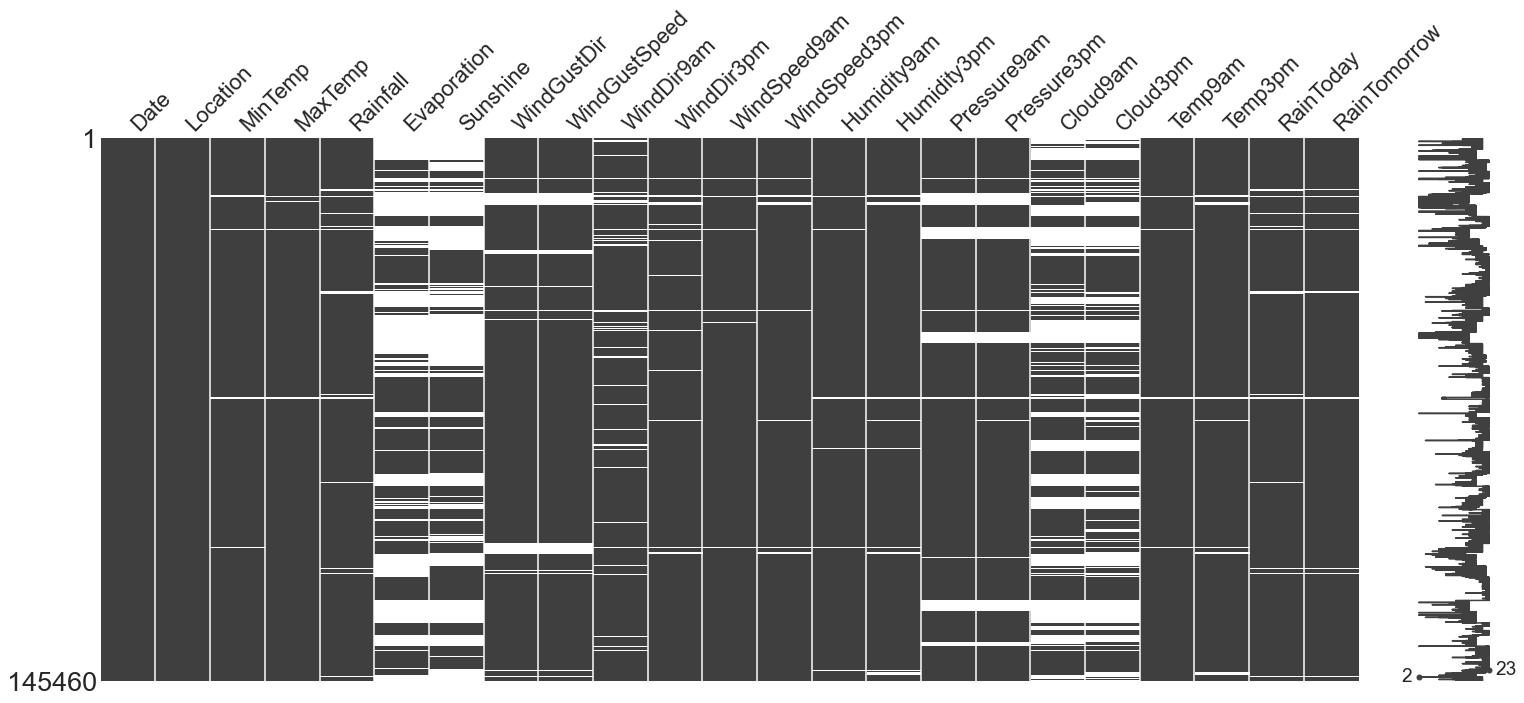

In [68]:
fig = missingno.matrix(df, fontsize= 22)
fig.get_figure().savefig('Figures/missing_values_overview.jpg',
                         dpi=500, bbox_inches= 'tight')

## Parsing Date

Date column is string which is not useful. Even though we are doing just EDA in this part (we have not split the data set into training and test set yet), we can parse the date and edit the original df right here as it won't cause any data leakage or anything. We are just reformatting date column.

In [212]:
# Parse date col
df['Date'] = pd.to_datetime(df['Date'])

# Create 3 new cols: Year, Month, Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop original date col
df.drop('Date', axis='columns', inplace=True)

df

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,...,1020.3,NaN,NaN,10.1,22.4,No,No,2017,6,21
145456,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,...,1019.1,NaN,NaN,10.9,24.5,No,No,2017,6,22
145457,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,...,1016.8,NaN,NaN,12.5,26.1,No,No,2017,6,23
145458,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,...,1016.5,3.0,2.0,15.1,26.0,No,No,2017,6,24


## Predictive Power Score

- The predictive power score (PPS) is an asymmetric, data-type-agnostic score that can detect linear or non-linear relationships between two columns. The score ranges from 0 (no predictive power) to 1 (perfect predictive power). 

- PPS is a very useful exploratory data analysis tool to get a sense of which features are powerful/weak predictors of the target variable. We can take a note of weak predictors here as "usual suspects" that can be possibly dropped later in the model training to increase model performance. 

- It can be used as an alternative to the correlation matrix. While correlation is only defined for numeric columns, PPS can also be used for categorical variables. Another vital difference between PPS and correlation is, correlation matrix is symmetric, but PPS is not. As an example, amount of *Rainfall* is a good predictor for *RainToday* (if it's above certain value we call it rained), so PPS of *Rainfall* for *RainToday* should be very high. However, the reverse is not true. By knowing it rained today we cannot confidently predict the amount of *Rainfall*; we can say it is above certain value, at best. Thus, PPS of *RainToday* for *Rainfall* should be low ([more info](https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598)).

In [19]:
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Year', 'Month', 'Day'],
      dtype='object')

In [213]:
ppscore_report = ppscore.matrix(df, 
                                sample= 5000,
                                # def= 5000, 3-5x for more precision 
                                )

# create PPS matrix from ppscore_report
pp_matrix = ppscore_report.pivot(columns='x', index='y', 
                                 values='ppscore')

# How much the variable under col "x" 
# predicts the variable under col "y"
pp_matrix

x,Cloud3pm,Cloud9am,Day,Evaporation,Humidity3pm,Humidity9am,Location,MaxTemp,MinTemp,Month,...,Sunshine,Temp3pm,Temp9am,WindDir3pm,WindDir9am,WindGustDir,WindGustSpeed,WindSpeed3pm,WindSpeed9am,Year
y,,,,,,,,,,,,,,,,,,,,,
Cloud3pm,1.000000,2.788849e-01,0.000000e+00,0.018472,0.195394,0.096444,4.145048e-02,0.025332,0.000000,0.000000e+00,...,0.368145,0.045378,0.000000,0.000000e+00,4.985464e-03,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
Cloud9am,0.289800,1.000000e+00,0.000000e+00,0.009840,0.177635,0.140178,6.197227e-02,0.021733,0.000000,0.000000e+00,...,0.367080,0.035007,0.000000,0.000000e+00,3.769756e-03,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
Day,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000e+00,8.235943e-04,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
Evaporation,0.014503,9.932329e-04,0.000000e+00,1.000000,0.086472,0.148585,5.668133e-02,0.215839,0.121916,1.991138e-01,...,0.121104,0.209178,0.217981,0.000000e+00,0.000000e+00,5.048584e-03,0.036334,0.000000,0.000000,0.000000e+00
Humidity3pm,0.172996,1.579452e-01,0.000000e+00,0.092468,1.000000,0.244486,1.713426e-01,0.121513,0.000000,1.051926e-02,...,0.204438,0.144941,0.000000,2.408208e-03,2.193967e-02,3.541445e-03,0.000000,0.000000,0.000000,4.489497e-04
Humidity9am,0.099707,1.333242e-01,0.000000e+00,0.160502,0.272253,1.000000,1.013191e-01,0.082393,0.000000,4.315333e-02,...,0.145537,0.087464,0.087575,0.000000e+00,1.250101e-02,7.013381e-03,0.038711,0.013170,0.042855,0.000000e+00
Location,0.000000,0.000000e+00,0.000000e+00,0.021326,0.013137,0.021563,1.000000e+00,0.023568,0.017016,0.000000e+00,...,0.014455,0.027041,0.026355,1.483069e-02,1.362793e-02,1.798673e-02,0.005039,0.000000,0.000000,0.000000e+00
MaxTemp,0.040542,4.058846e-02,0.000000e+00,0.295263,0.158592,0.130978,1.736132e-01,1.000000,0.296373,2.417368e-01,...,0.134030,0.851932,0.530315,3.366064e-02,5.708728e-02,5.014807e-02,0.024445,0.003075,0.000000,9.086563e-04
MinTemp,0.000000,9.330211e-03,0.000000e+00,0.194891,0.004029,0.021462,2.046654e-01,0.289950,1.000000,2.318994e-01,...,0.009128,0.277379,0.574902,4.531563e-02,2.385271e-02,4.460575e-02,0.031836,0.017258,0.019600,0.000000e+00


Features seem to be shuffled, let's reorder them for more readable plots

In [72]:
features_reordered = ['RainTomorrow', 'RainToday', 'Rainfall', 
                      'Cloud3pm', 'Cloud9am', 
                      'Evaporation', 'Humidity3pm', 'Humidity9am',
                      'MaxTemp', 'MinTemp', 'Temp3pm', 'Temp9am', 'Sunshine',
                      'Pressure3pm', 'Pressure9am',
                      'WindGustSpeed', 'WindSpeed3pm', 'WindSpeed9am', 
                      'WindGustDir', 'WindDir3pm', 'WindDir9am', 
                      'Location',
                      'Day', 'Month', 'Year',
                      ]

In [73]:
# re-order columns
pp_matrix = pp_matrix[features_reordered]

# re-order index
pp_matrix = pp_matrix.reindex(features_reordered)

# How much the variable under col "x" 
# predicts the variable under col "y"
pp_matrix

x,RainTomorrow,RainToday,Rainfall,Cloud3pm,Cloud9am,Evaporation,Humidity3pm,Humidity9am,MaxTemp,MinTemp,...,WindGustSpeed,WindSpeed3pm,WindSpeed9am,WindGustDir,WindDir3pm,WindDir9am,Location,Day,Month,Year
y,,,,,,,,,,,,,,,,,,,,,
RainTomorrow,1.000000e+00,1.387791e-07,0.123350,0.256124,1.328724e-07,0.003976,0.334958,0.092744,0.049120,0.025403,...,0.104485,0.014036,0.000245,1.738336e-07,1.333404e-07,1.738336e-07,1.748404e-07,1.748404e-07,1.748404e-07,1.748404e-07
RainToday,1.758736e-07,1.000000e+00,1.000000,0.000000,5.020373e-02,0.044977,0.133463,0.253468,0.034653,0.003241,...,0.001968,0.015121,0.006297,1.328724e-07,1.818617e-07,1.317393e-07,1.795175e-07,1.795175e-07,1.795175e-07,1.795175e-07
Rainfall,0.000000e+00,1.033707e-01,1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Cloud3pm,8.057390e-02,5.169707e-02,0.053622,1.000000,2.788849e-01,0.018472,0.195394,0.096444,0.025332,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,4.985464e-03,4.145048e-02,0.000000e+00,0.000000e+00,0.000000e+00
Cloud9am,6.331475e-02,5.834014e-02,0.069591,0.289800,1.000000e+00,0.009840,0.177635,0.140178,0.021733,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,3.769756e-03,6.197227e-02,0.000000e+00,0.000000e+00,0.000000e+00
Evaporation,0.000000e+00,1.576280e-02,0.021926,0.014503,9.932329e-04,1.000000,0.086472,0.148585,0.215839,0.121916,...,0.036334,0.000000,0.000000,5.048584e-03,0.000000e+00,0.000000e+00,5.668133e-02,0.000000e+00,1.991138e-01,0.000000e+00
Humidity3pm,9.101010e-02,6.900163e-02,0.088595,0.172996,1.579452e-01,0.092468,1.000000,0.244486,0.121513,0.000000,...,0.000000,0.000000,0.000000,3.541445e-03,2.408208e-03,2.193967e-02,1.713426e-01,0.000000e+00,1.051926e-02,4.489497e-04
Humidity9am,3.582957e-02,8.090716e-02,0.098091,0.099707,1.333242e-01,0.160502,0.272253,1.000000,0.082393,0.000000,...,0.038711,0.013170,0.042855,7.013381e-03,0.000000e+00,1.250101e-02,1.013191e-01,0.000000e+00,4.315333e-02,0.000000e+00
MaxTemp,1.352949e-02,3.004554e-02,0.044566,0.040542,4.058846e-02,0.295263,0.158592,0.130978,1.000000,0.296373,...,0.024445,0.003075,0.000000,5.014807e-02,3.366064e-02,5.708728e-02,1.736132e-01,0.000000e+00,2.417368e-01,9.086563e-04


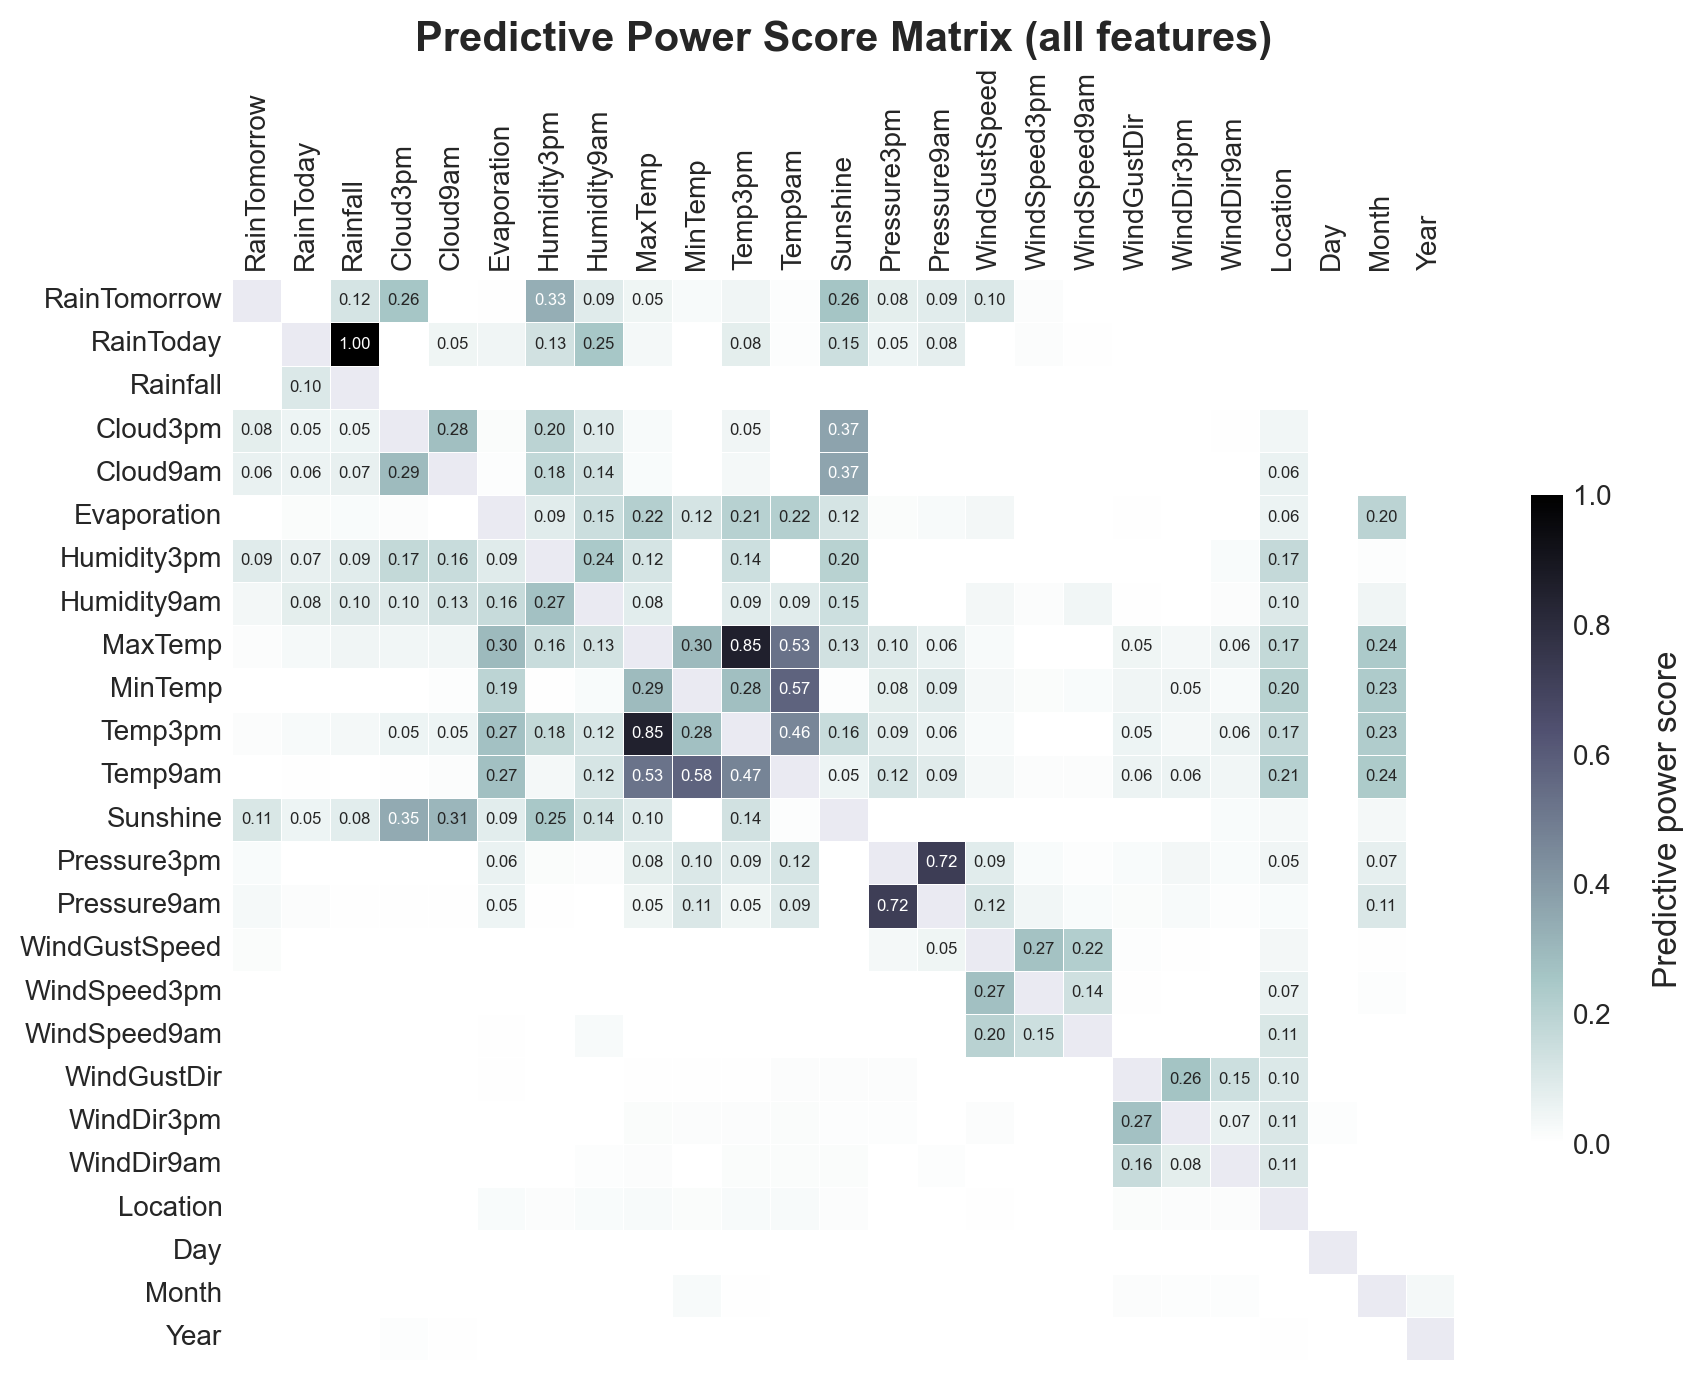

In [74]:
# Plot PPS matrix
fig, ax = plt.subplots(figsize=(9,7), dpi=200)

cbar_kws = {
    'shrink': 0.6,  # Adjust size of the cbar
    'aspect': 20,  # Control aspect ratio of the cbar
    'pad': 0.05,  # Add padding between heatmap and cbar
    'label': 'Predictive power score',  # Set cbar label
    'orientation': 'vertical',  # Vertical or horizontal
}

annot_kws = {
    'fontsize': 6  # fontsize for annotation labels
}

# Create mask to turn off diagonal elements in heatmap
mask = np.eye(len(pp_matrix), dtype=bool)

# good colormaps: Blues, bone_r ,  
ax = sns.heatmap(pp_matrix, linewidth=0.3, cmap='bone_r',
                 annot=True, fmt='.2f', mask=mask, cbar=True,
                 cbar_kws=cbar_kws, annot_kws=annot_kws)

# Turn off annotation of cell values less than 0.05
# to reduce clutter in the plot
for text in ax.texts:
    cell_value = float(text.get_text())
    if  cell_value < 0.05:
        text.set_text('') 

# Move colorbar label further away from the bar
cbar = ax.collections[0].colorbar
cbar.set_label(cbar_kws['label'], labelpad=15, fontsize=12)

# Rotate x-axis tick labels
_ = ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=90, ha='center')

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Predictive Power Score Matrix (all features)', 
             fontsize=15, fontweight='bold')
ax.grid(False)

fig.tight_layout()
fig.savefig('Figures/predictive_power_score.jpg', dpi= 500)

<u>How to read the plot</u>
- Vertical axis features are to be predicted by the horizontal axis features

- Only PPS > 0.05 are printed to reduce clutter. Diagonal elements are also masked

<u>Comments</u>
- *Humidity3pm* is the strongest predictor for *RainTomorrow*. *Cloud3pm* and *Sunshine* are the next strongest ones.

- Date-related cols (*Day, Month, Year*) and wind direction-related cols (*WindGustDir, WindDir3pm, WindDir9am*) have ~0 PPS in predicting *RainTomorrow*. These features also have very weak PPS with other features except that *Month* has significant PPS in predicting *Evaporation* and temperature-related columns which makes sense. We might consider dropping these 6 cols altogether if a need be in the training phase.

<u>Limitations of PPS</u>
- Authors of the `ppscore` note that *"If you use the PPS for feature selection you still want to perform forward and backward selection in addition. Also, the PPS cannot detect interaction effects between features towards your target"*. So, we should not solely use PPS matrix to immediately drop some features.

- *"The score cannot be interpreted as easily as the correlation because it does not tell you anything about the type of relationship that was found. Thus, the PPS is better for finding patterns but the correlation is better to communicate found linear relationships"*

# EDA – CATEGORICAL VARIABLES

## Location

In [17]:
print(f'There are {df["Location"].value_counts().size} cities')
df["Location"].value_counts()

There are 49 cities


Canberra            3436
Sydney              3344
Darwin              3193
Melbourne           3193
Brisbane            3193
Adelaide            3193
Perth               3193
Hobart              3193
Albany              3040
MountGambier        3040
Ballarat            3040
Townsville          3040
GoldCoast           3040
Cairns              3040
Launceston          3040
AliceSprings        3040
Bendigo             3040
Albury              3040
MountGinini         3040
Wollongong          3040
Newcastle           3039
Tuggeranong         3039
Penrith             3039
Woomera             3009
Nuriootpa           3009
Cobar               3009
CoffsHarbour        3009
Moree               3009
Sale                3009
PerthAirport        3009
PearceRAAF          3009
Witchcliffe         3009
BadgerysCreek       3009
Mildura             3009
NorfolkIsland       3009
MelbourneAirport    3009
Richmond            3009
SydneyAirport       3009
WaggaWagga          3009
Williamtown         3009


There are 49 cities and each city has between 1578-3436 days (4.3-9.4 years) of data

## Target variable: RainTomorrow

In [53]:
df['RainTomorrow'].value_counts(dropna=False)

No     110316
Yes     31877
NaN      3267
Name: RainTomorrow, dtype: int64

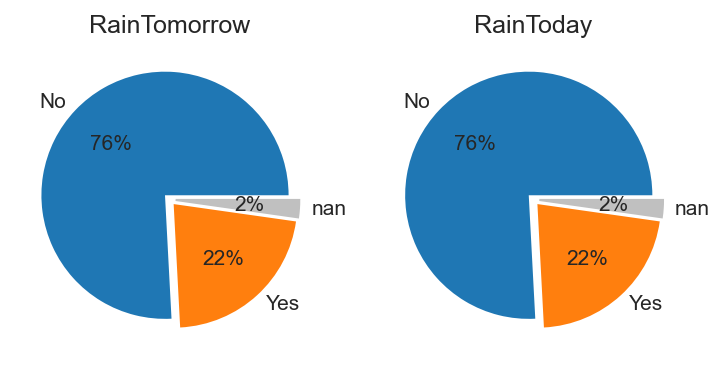

In [76]:
rain_cols = ['RainTomorrow', 'RainToday']
fig, ax = plt.subplots(1,2, figsize=(5,2.5), dpi=150)

for order, rain_col in enumerate(rain_cols):
    counts = df[rain_col].value_counts(dropna=False)
    nan_loc = counts.index.get_loc(np.nan) # loc of missing label
    pie_chart = ax[order].pie(counts.values, labels=counts.index, 
                              explode=(0.05,0.05,0.05), 
                              shadow=False, autopct='%1.0f%%')

    # set color of nan to gray
    pie_chart[0][nan_loc].set_color('silver') 
    ax[order].set_title(rain_col)

fig.set_facecolor('white')
fig.tight_layout()
fig.savefig('Figures/rain_tomorrow_distribution.jpg', dpi=500)

- We have somewhat imbalanced target variable which will be something to consider in the evaluation part.

- ~2% is missing for both tomorrow and today rain. 

- *RainTomorrow* is the target variable and we can't do anything about missing values in it. Imputing missing values in the target variable could add significant bias. Since it's only 2% it won't hurt to just delete the rows whose *RainTomorrow" is missing. Will do later in the feature engineering part.   

## Binarize Target Variable: RainTomorrow

Convert Yes, No labels into 1, 0 in *RainTomorrow* as tree-based models e.g. XGBoost do not natively work with labels. *RainToday* column will be handled along with the other categorical variables later in one-hot encoding part of feature engineering.

In [77]:
# Note that pd.get_dummies(...) converts NaN into 0! 
# So, we lose missing values
# To keep NaN's, use little hack below

df['RainTomorrow'] = pd.get_dummies(df['RainTomorrow'].dropna())['Yes'].reindex(df.index)

df['RainTomorrow']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
145455    0.0
145456    0.0
145457    0.0
145458    0.0
145459    NaN
Name: RainTomorrow, Length: 145460, dtype: float64

Looking good, NaN's inplace &#128077;

## Wind columns: WindGustDir, WindDir9am, WindDir3pm

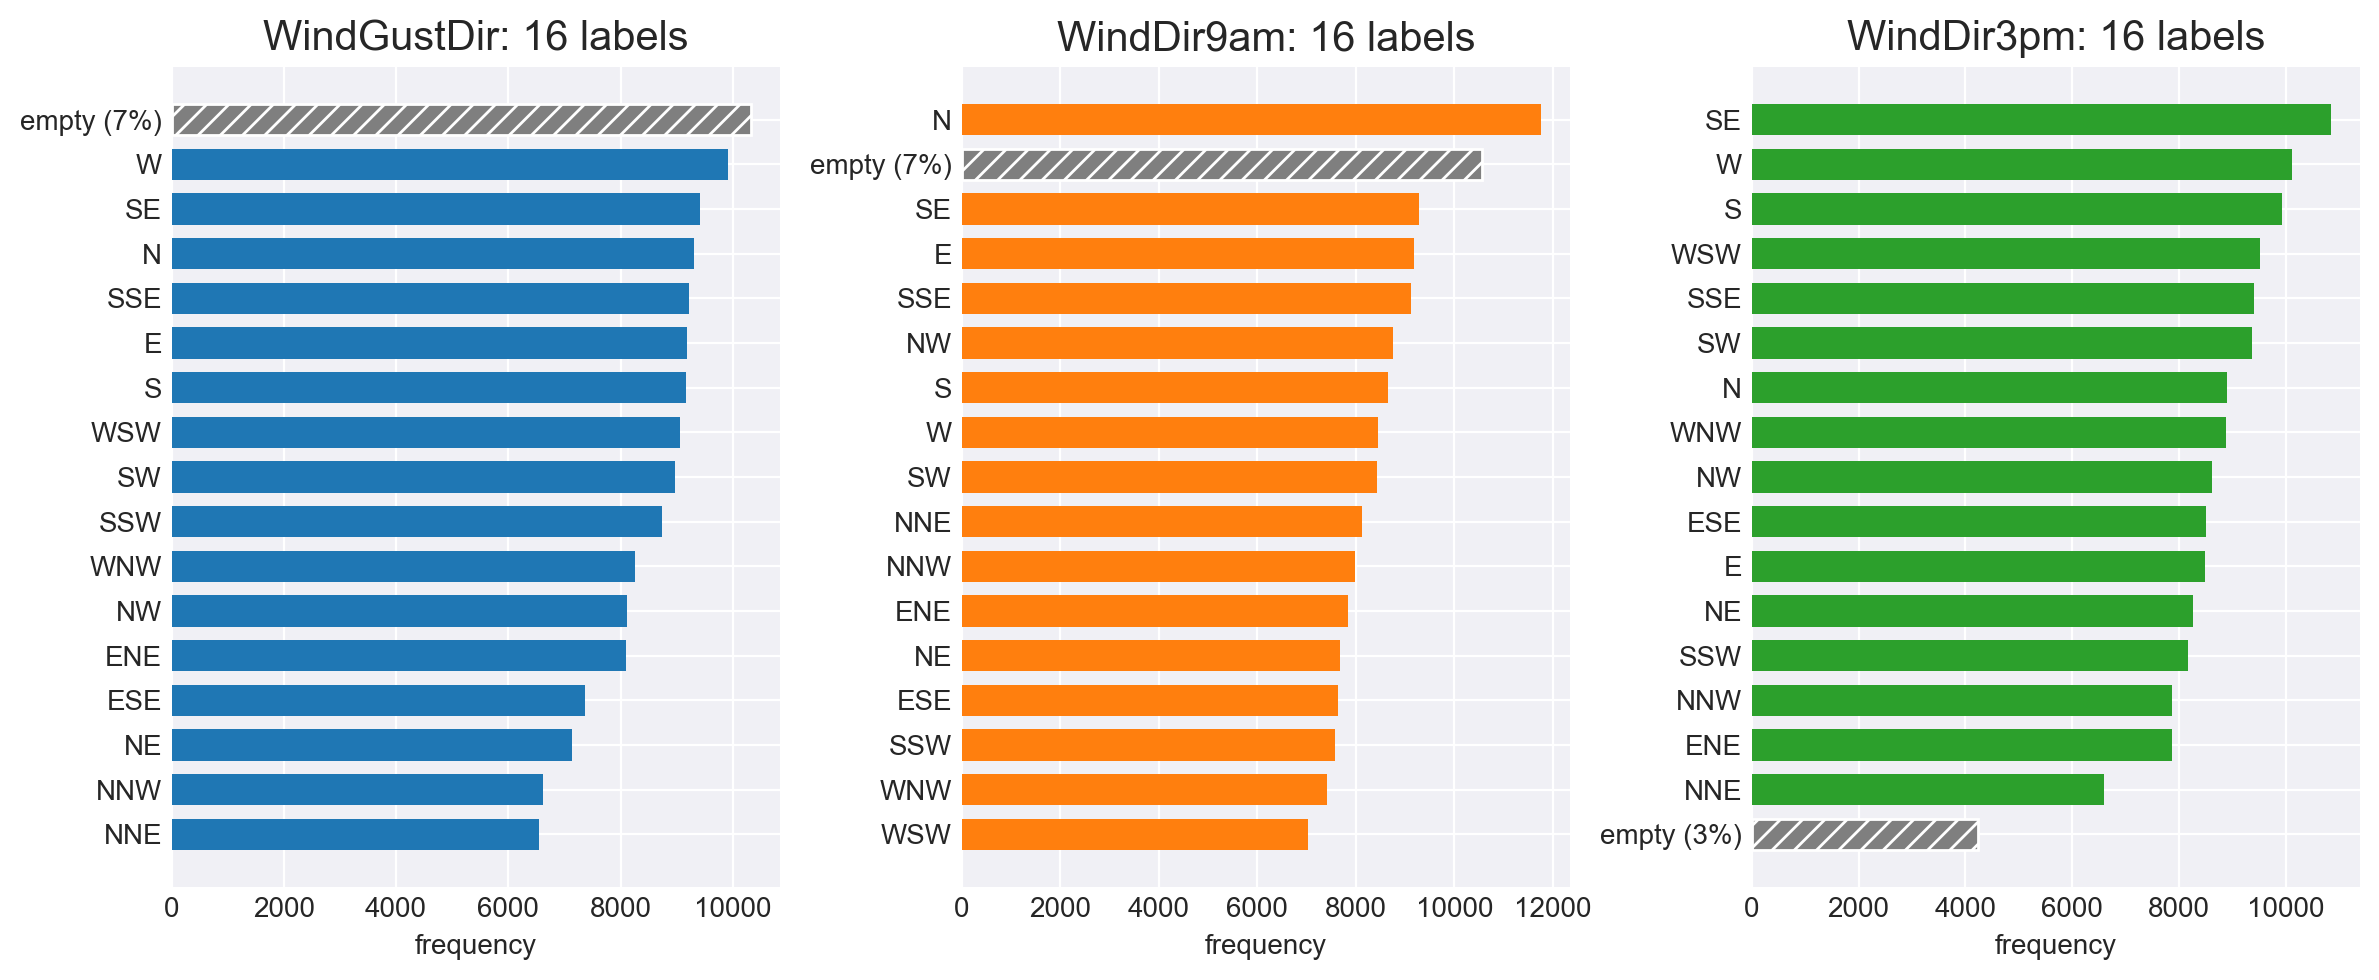

In [78]:
wind_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
fig, ax = plt.subplots(1,3, figsize=(12,5), dpi=200)

# Get matplotlib default colors list
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

for order, wind_col in enumerate(wind_cols):
    wind_counts = df[wind_col].value_counts(dropna=False, 
                                            ascending=True)
    wind_labels = wind_counts.index.to_list()

    # One of the labels present is np.nan which is a float
    # Replace it with a string so that it can be displayed in plot
    nan_loc = wind_counts.index.get_loc(np.nan)
    percent_empty = wind_counts[nan_loc]/len(df)*100
    wind_labels[nan_loc] = f'empty ({percent_empty:.0f}%)'
 
    bars = ax[order].barh(wind_labels, wind_counts, 
                          height=0.7, color=colors[order])
    # Use different color for 'missing' bar and use shadding 
    bars[nan_loc].set_color('tab:gray')
    bars[nan_loc].set_hatch('///')
    bars[nan_loc].set_edgecolor('white')

    ax[order].set_title(f'{wind_col}: {len(wind_labels)-1} labels', 
                        fontsize=15)
    ax[order].set_xlabel('frequency')

    # set background whiter
    ax[order].patch.set_alpha(0.7)    

fig.tight_layout()
fig.savefig('Figures/wind_columns.jpg', dpi=500)

Not much going on here. Balanced labels with 16 labels in each wind column, 2-7% missing entries. 

# EDA – NUMERICAL VARIABLES

## Box Plots

In [79]:
# select categorical variables whose dtype is not object
boxplot_cols = df.select_dtypes(exclude=['object']).columns.tolist()

# remove Year, Month, Day (not informative for box plot) 
# also remove the binary RainToday and RainTomorrow cols
remove_cols = ['Year', 'Month', 'Day', 'RainToday', 'RainTomorrow']
boxplot_cols = [x for x in boxplot_cols if x not in remove_cols]

boxplot_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

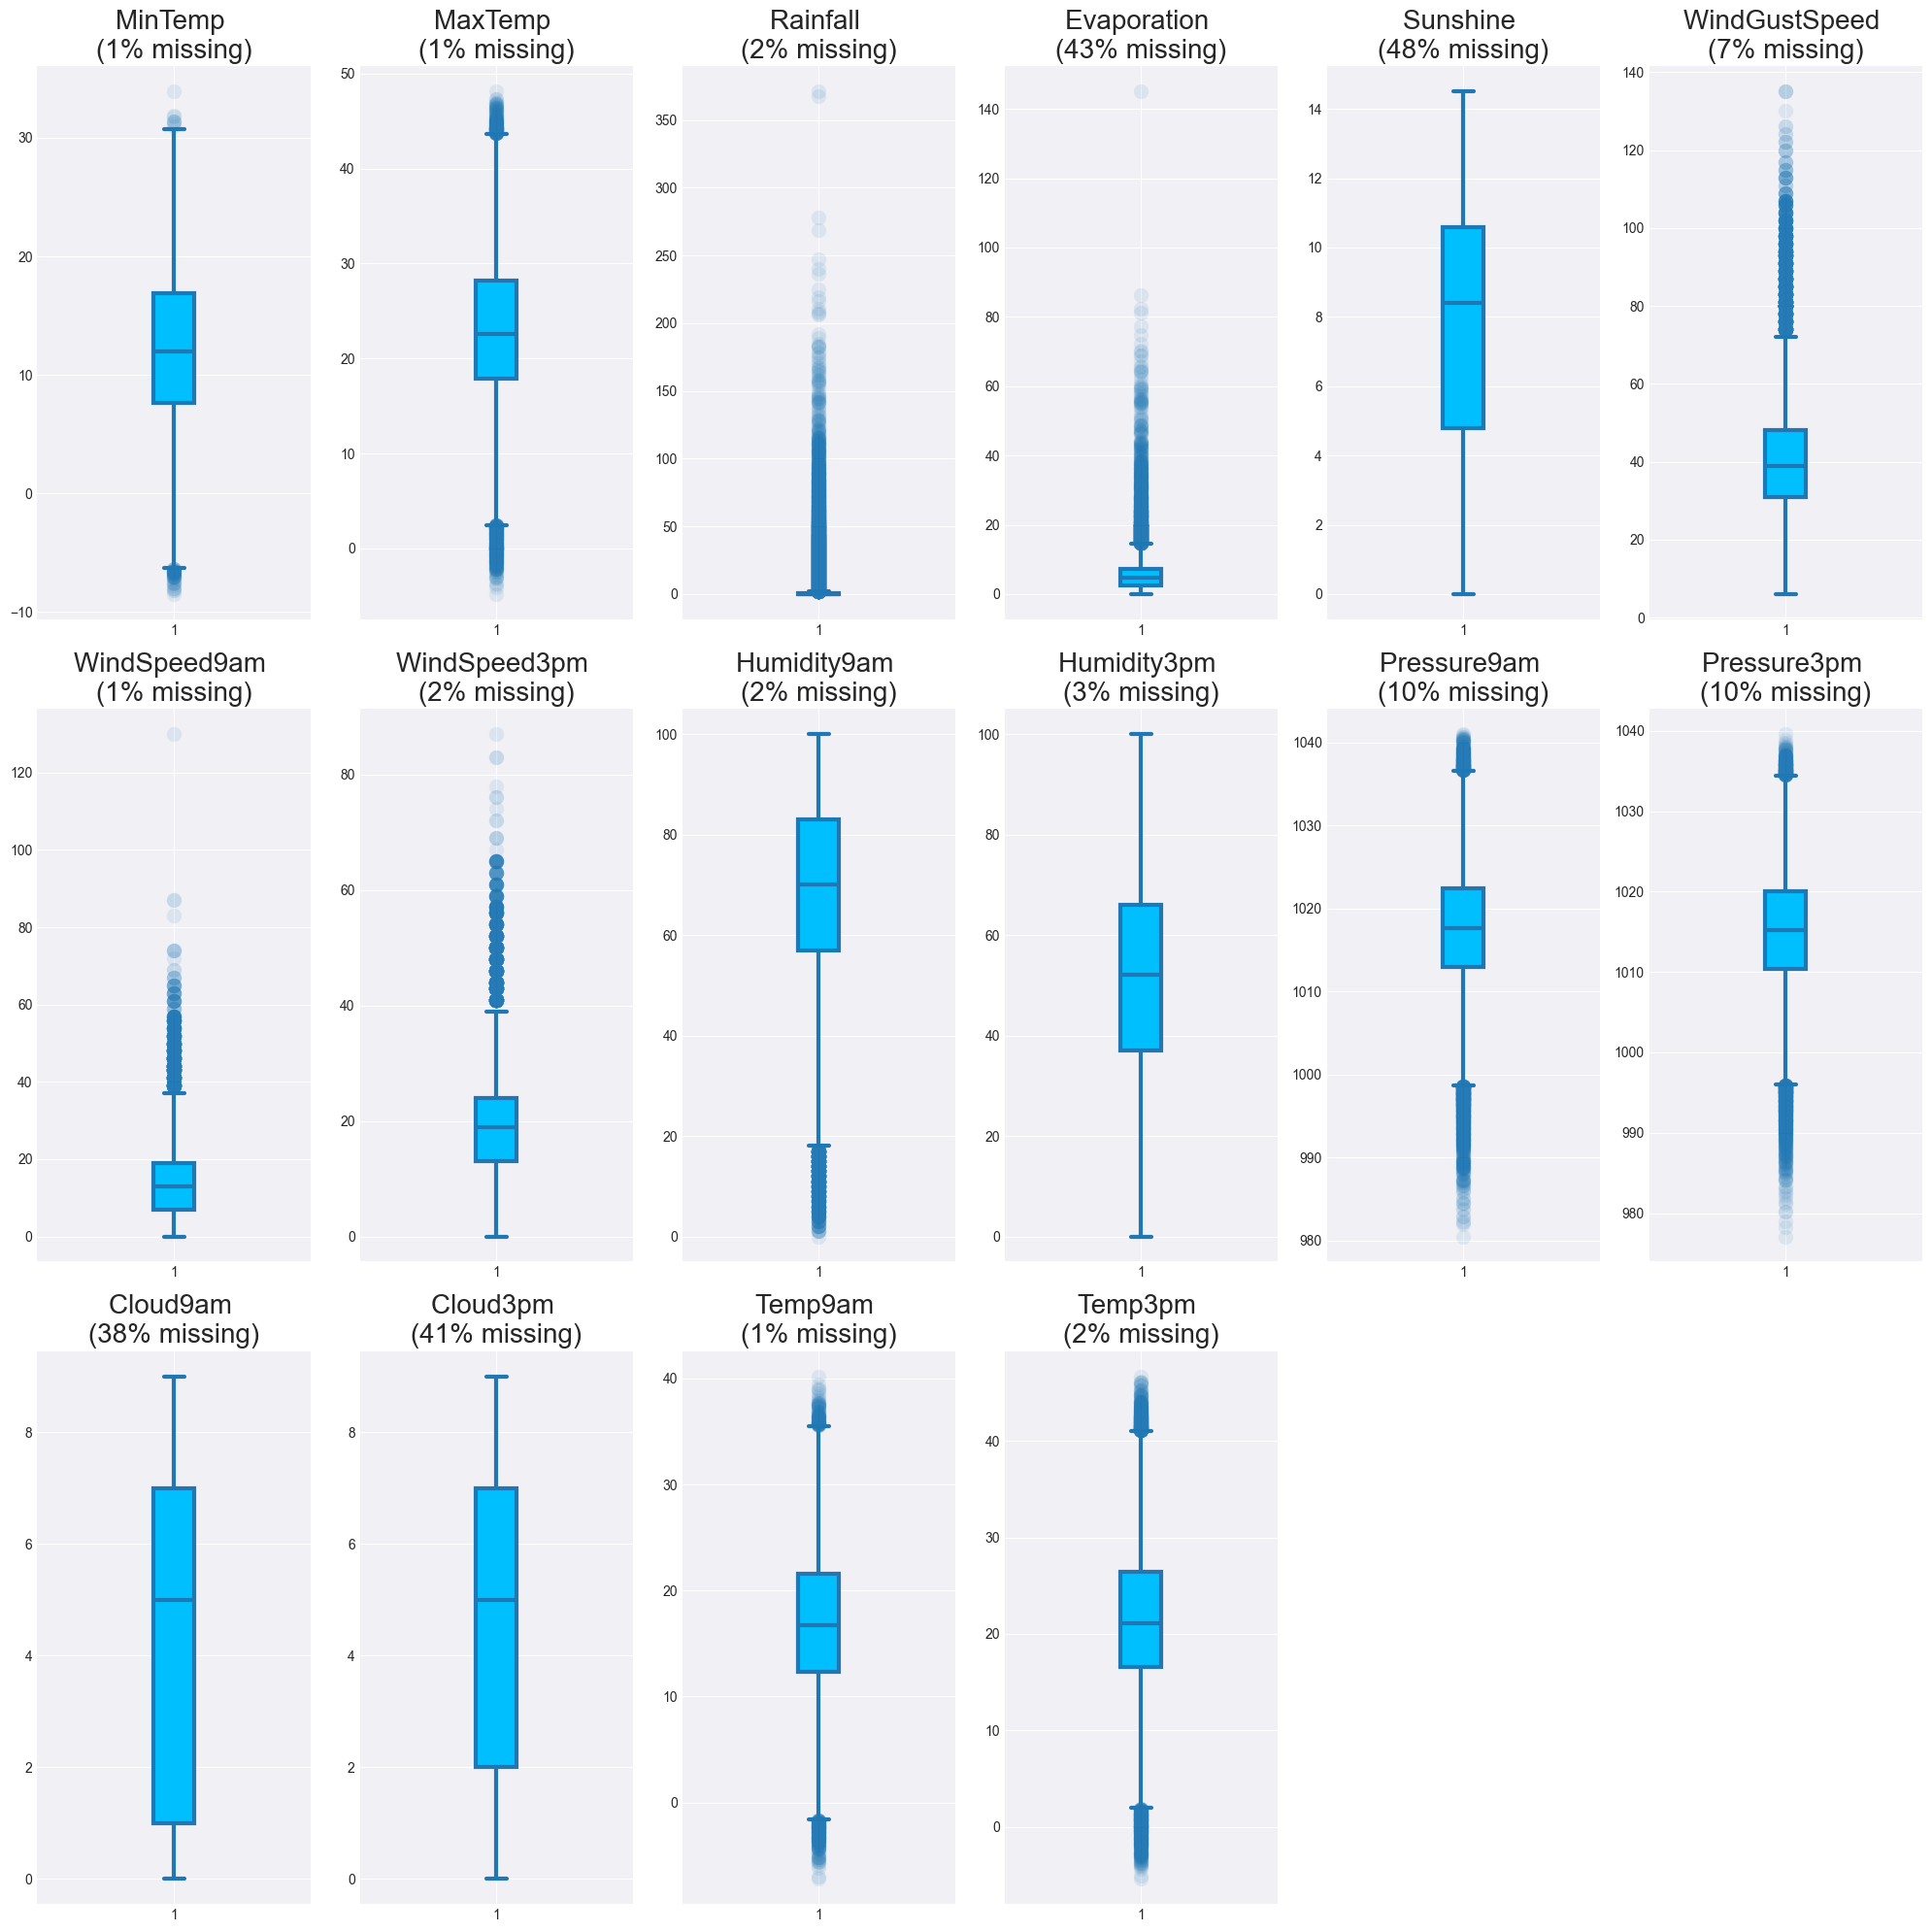

In [80]:
N_cols = 6  # num of cols in a row to plot 
N_rows = len(boxplot_cols) // N_cols + 1
fig, axes = plt.subplots(N_rows, N_cols, figsize=(20,20), dpi=100)

image_id = 0
for row_id in range(N_rows):
    for col_id in range(N_cols):

        ax = axes[row_id, col_id]
        if image_id < len(boxplot_cols):
            col_name = boxplot_cols[image_id]  
            set_edgecolor = 'tab:blue'
            set_facecolor = 'deepskyblue'
            set_lw = 3.0

            ax.boxplot(df[col_name].dropna(),
                       patch_artist=True, widths=0.15,
                       boxprops=dict(facecolor=set_facecolor,
                                     edgecolor=set_edgecolor, lw=set_lw),
                       medianprops=dict(color=set_edgecolor, lw=set_lw),
                       whiskerprops=dict(color=set_edgecolor, lw=set_lw),
                       capprops=dict(color=set_edgecolor, lw=set_lw),
                       flierprops=dict(markerfacecolor=set_edgecolor,
                                       markeredgecolor='none',
                                       alpha=0.1, markersize=11) )
            
            percent_empty = df[col_name].isna().sum() / len(df) *100
            ax.set_title(f'{col_name} \n({percent_empty:.0f}% missing)',
                         fontsize=20)
            
            # set background whiter
            ax.patch.set_alpha(0.7)

        else:
            # delete empty subplots
            fig.delaxes(ax)
        image_id += 1

fig.tight_layout()
fig.savefig('Figures/outliers_numerical_features.jpg', dpi=500)

<u>Comments</u>
- *Rainfall* and *Evaporation* have clearly lots of outliers that needs to be handled

- *WindGustSpeed, WindSpeed9am* and *WindSpeed3pm* also arguably have many outliers. 

- These variables look heavily skewed.

- *Evaporation, Sunshine, Cloud9am* and *Cloud3pm* have way too many missing values. We should choose a good strategy when doing missing value imputation for these cols

## Correlation Matrix

In [81]:
# Select categorical variables whose dtype is not object
corrplot_cols = df.select_dtypes(exclude=['object']).columns.tolist()

# Do not plot Year, Month, Day (not informative)
remove_cols = ['Year', 'Month', 'Day']
corrplot_cols = [x for x in corrplot_cols if x not in remove_cols]

corrplot_cols

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow']

In [82]:
# calculate correlation between numerical cols
correlation = df[corrplot_cols].corr()

correlation

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainTomorrow
MinTemp,1.000000,0.736555,0.103938,0.466993,0.072586,0.177415,0.175064,0.175173,-0.232899,0.006089,-0.450970,-0.461292,0.078754,0.021605,0.901821,0.708906,0.083936
MaxTemp,0.736555,1.000000,-0.074992,0.587932,0.470156,0.067615,0.014450,0.050300,-0.504110,-0.508855,-0.332061,-0.427167,-0.289370,-0.277921,0.887210,0.984503,-0.159237
Rainfall,0.103938,-0.074992,1.000000,-0.064351,-0.227549,0.133659,0.087338,0.057887,0.224405,0.255755,-0.168154,-0.126534,0.198528,0.172403,0.011192,-0.079657,0.239032
Evaporation,0.466993,0.587932,-0.064351,1.000000,0.365602,0.203021,0.193084,0.129400,-0.504092,-0.390243,-0.270362,-0.293581,-0.183793,-0.182618,0.545115,0.572893,-0.119285
Sunshine,0.072586,0.470156,-0.227549,0.365602,1.000000,-0.034750,0.005499,0.053834,-0.490819,-0.629130,0.041970,-0.019719,-0.675323,-0.703930,0.291188,0.490501,-0.450768
WindGustSpeed,0.177415,0.067615,0.133659,0.203021,-0.034750,1.000000,0.605303,0.686307,-0.215070,-0.026327,-0.458744,-0.413749,0.071736,0.109168,0.150150,0.032748,0.234010
WindSpeed9am,0.175064,0.014450,0.087338,0.193084,0.005499,0.605303,1.000000,0.519547,-0.270858,-0.031614,-0.228743,-0.175817,0.025112,0.054639,0.128545,0.004569,0.090995
WindSpeed3pm,0.175173,0.050300,0.057887,0.129400,0.053834,0.686307,0.519547,1.000000,-0.145525,0.016432,-0.296351,-0.255439,0.053337,0.025396,0.163030,0.027778,0.087817
Humidity9am,-0.232899,-0.504110,0.224405,-0.504092,-0.490819,-0.215070,-0.270858,-0.145525,1.000000,0.666949,0.139442,0.186858,0.452297,0.357326,-0.471354,-0.498399,0.257161
Humidity3pm,0.006089,-0.508855,0.255755,-0.390243,-0.629130,-0.026327,-0.031614,0.016432,0.666949,1.000000,-0.027544,0.051997,0.517120,0.523120,-0.221019,-0.557841,0.446160


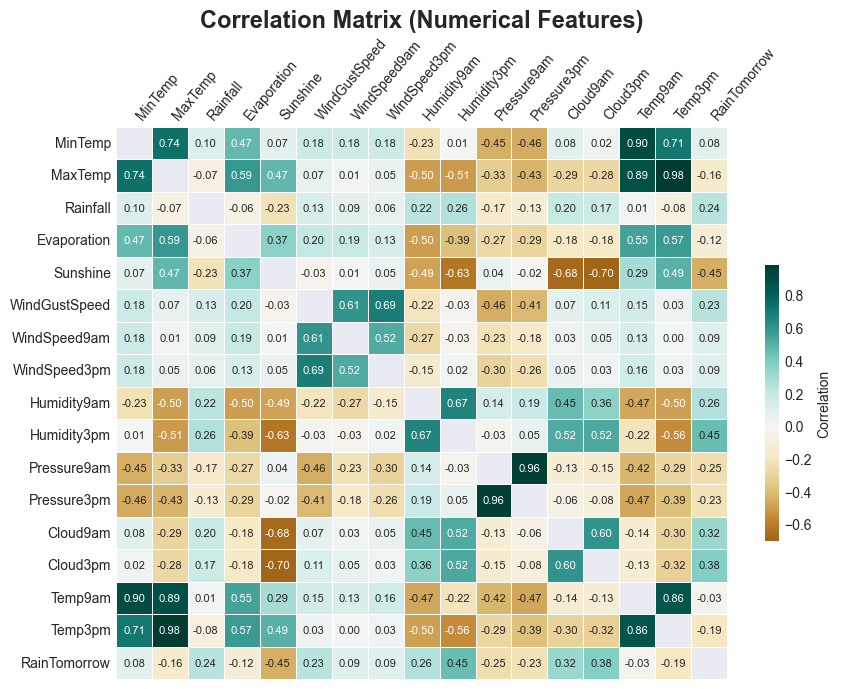

In [83]:
# plot cross correlations
fig, ax = plt.subplots(figsize=(9,7), dpi=100)

cbar_kws = {
    'shrink': 0.5,  # Adjust size of cbar
    'aspect': 20,  # Control aspect ratio of cbar
    'pad': 0.05,  # Padding between heatmap and cbar
    'label': 'Correlation',  # Cbar label
    'orientation': 'vertical',  # Vertical or horizontal
}

annot_kws = {
    'fontsize': 8  # Fontsize for annotation labels
}

# create mask to turn off diagonal elements in heat map
mask = np.eye(len(correlation), dtype=bool)

# good colormaps: BrBG, PRGn, RdBu
ax = sns.heatmap(correlation, linewidth=0.4, cmap='BrBG',
                 annot=True, fmt='.2f', cbar=True, 
                 center=0,  # make sure center matches 0
                 cbar_kws=cbar_kws, annot_kws=annot_kws, 
                 mask=mask)

_ = ax.set_xticklabels(ax.get_xticklabels(), 
                       rotation=50, ha='left')

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_title('Correlation Matrix (Numerical Features)', 
             fontweight='bold', fontsize=17)
ax.grid(False)

fig.tight_layout()
fig.savefig('Figures/correlation_matrix.jpg', dpi=500)

<u>Comments</u>
- *RainTomorrow* is most correlated with *Humidity3pm* (0.45), *Sunshine* (-0.45) and *Cloud3pm* (0.38). Also it is significantly correlated with *RainToday* (0.31) which all makes sense.   

- Temperature-related cols and pressure-related cols are highly correlated within their groups as expected e.g. (*MinTemp, Temp9am*) = 0.9 or (*MinTemp, MaxTemp*) = 0.74

- We might consider discarding one of the extremely high correleted pairs eg. (*MaxTemp, Temp3pm*) = 0.98 or (*Pressure9am, Pressure3pm*) = 0.96. Extremely highly correlated features might be a problem for some algos. We should plot pair plot for these pairs to see them in more detail.

- *Cloud3pm* and *Sunshine* are highly negatively correlated -0.7 which makes sense. Or, *Humidity3pm* and *Sunshine* are also significantly negatively correlated: -0.63.

## Pair Plot

Let's inspect highly correlated variables in pair plots.

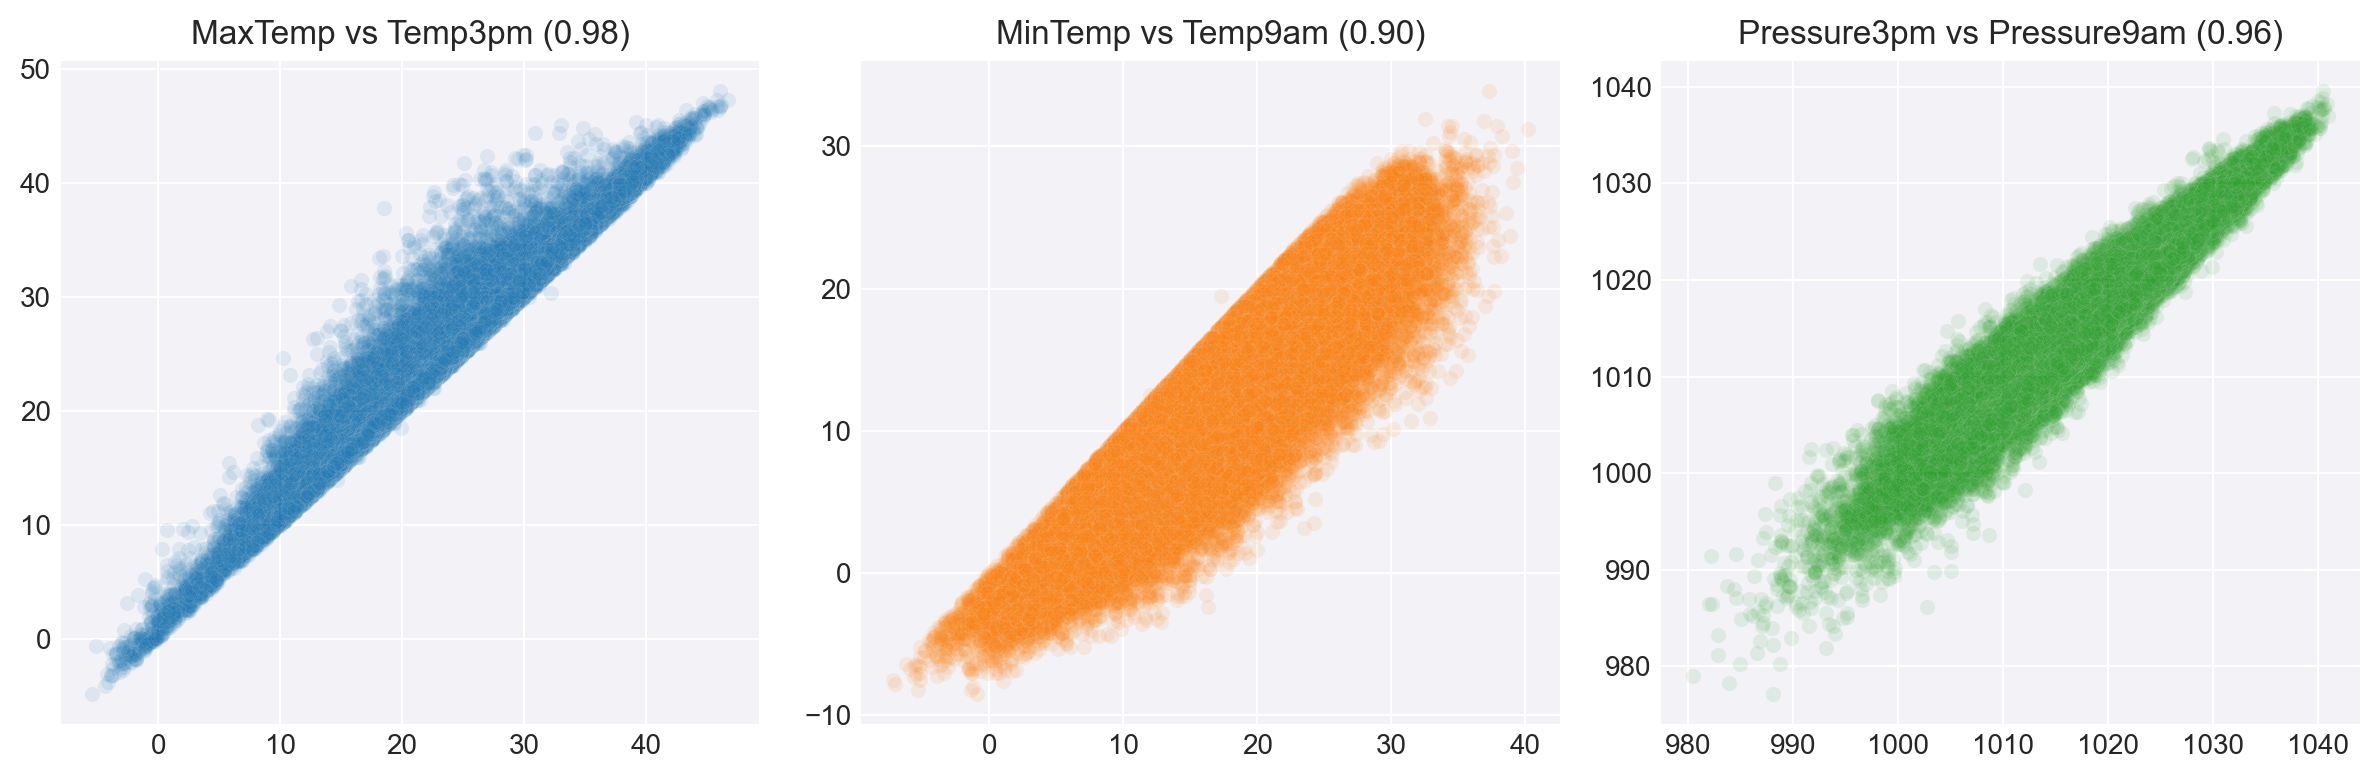

In [84]:
plot_pairs = (('MaxTemp','Temp3pm'), 
              ('MinTemp','Temp9am'), 
              ('Pressure3pm','Pressure9am'), 
              )

fig, axes = plt.subplots(1,len(plot_pairs), 
                       figsize=(12,4), dpi=200)

# default matplotlib colors list
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] 

for order, pair in enumerate(plot_pairs):
    var_x = pair[1]
    var_y = pair[0]
    ax = axes[order]

    ax.scatter(df[var_x], df[var_y], alpha=0.1, 
                      fc=colors[order], ec='white', 
                      lw=0.2, s=30)
    
    pair_corr = correlation.loc[var_x,var_y]
    ax.set_title(f'{var_y} vs {var_x} ({pair_corr:.2f})')

    # set background whiter
    ax.patch.set_alpha(0.6)

fig.tight_layout()
fig.savefig('Figures/highly_correlated_features.jpg', dpi=500)

<u>Comments</u>

We can possibly discard one of the variables in each plot without compromising much info. 



# SPLITTING DATA

In [86]:
X = df.drop(['RainTomorrow'], axis= 'columns')
y = df['RainTomorrow']

In [87]:
# Allocate 20% for test set
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
                                X, y, test_size= 0.2,
                                random_state= random_state)
display(
        f'X_train_raw: {X_train_raw.shape}', 
        f'X_test_raw: {X_test_raw.shape}',
        f'y_train: {y_train.shape}',
        f'y_test: {y_test.shape}'
        )

'X_train_raw: (116368, 24)'

'X_test_raw: (29092, 24)'

'y_train: (116368,)'

'y_test: (29092,)'

# FEATURE ENGINEERING

## Drop Multicollinear Features

Multicollinearity can make it challenging to interpret the individual contributions of correlated predictors in a regression model. Multicollinearity in features can lead to:

- Reduced model interpretability: it becomes difficult to isolate the effect of each predictor on the dependent variable.

- Difficulty in identifying significant predictors: multicollinearity can make it harder to identify which predictors are truly important.

- Unstable coefficients: small changes in the data can lead to substantial changes in the coefficient estimates.

Hence, we will drop following 3 cols (and keep the ones in paranthesis):
- *MaxTemp* (0.98 corr with *Temp3pm*)
- *MinTemp* (0.90 corr with *Temp9am*)
- *Pressure9am* (0.96 corr with *Pressure3pm*)

In [88]:
collinear_cols = ['MaxTemp', 'MinTemp', 'Pressure9am']

X_train_raw.drop(collinear_cols, axis= 'columns', inplace= True)
X_test_raw.drop(collinear_cols, axis= 'columns', inplace= True)

## Missing Values in Target Variable

As shown in the EDA part, 2% is missing in the RainTomorrow col. We will just delete the corresponding rows. We should not do imputation for the target variable as it would introduce bias. 

In [89]:
# drop rows with missing target value in train
y_train.dropna(inplace= True)
X_train_raw = X_train_raw.loc[y_train.index]

# drop rows with missing target value in test
y_test.dropna(inplace= True)
X_test_raw = X_test_raw.loc[y_test.index]

In [90]:
y_train.shape

(113740,)

## Missing Values in Features

In [91]:
# show missing value counts and percent 
# for each col_name along with their dtype 
missing_df = pd.DataFrame(index= X_train_raw.columns)

missing_df['missing'] = X_train_raw.isnull().sum().values
missing_df['percent'] = missing_df['missing'] / len(X_train_raw) * 100
missing_df['dtypes'] = X_train_raw.dtypes.values

# print categorical variables first and sort by missing percent
missing_df.sort_values(by= ['dtypes', 'percent'], 
                       ascending= False, inplace= True)

missing_df

,missing,percent,dtypes
WindDir9am,8038,7.066995,object
WindGustDir,7447,6.547389,object
WindDir3pm,3016,2.651662,object
RainToday,1119,0.983823,object
Location,0,0.000000,object
Sunshine,54117,47.579567,float64
Evaporation,48648,42.771233,float64
Cloud3pm,45591,40.083524,float64
Cloud9am,42887,37.706172,float64
Pressure3pm,11171,9.821523,float64


First 5 cols are categorical and the rest are numerical. All columns except *Location* and Date-related cols have missing values. *Sunshine* and *Evaporation* cols have near 50% missing values!

In [92]:
# define categorical and numerical cols
categorical_cols = [col for col in X_train_raw.columns 
                    if X_train_raw[col].dtypes == 'O']

numerical_cols = [col for col in X_train_raw.columns 
                  if X_train_raw[col].dtypes != 'O']

categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

## Missing Values Imputation - Categorical Variables

In [93]:
missing_df.loc[categorical_cols].sort_values(by= 'percent', 
                                             ascending= False)

,missing,percent,dtypes
WindDir9am,8038,7.066995,object
WindGustDir,7447,6.547389,object
WindDir3pm,3016,2.651662,object
RainToday,1119,0.983823,object
Location,0,0.000000,object


<u>Comments</u>
- Reasonable number of missing values in three wind-related cols

- Small percentage is missing in RainToday

- No missing value in Location

Fill in missing values with the **mode** of each variable using `SimpleImputer` from `sklearn`. To avoid data leakage, find the mode from training data and then impute missing values both in training and test set. 

In [95]:
# Before imputation
X_train_raw[categorical_cols].isna().sum()

Location          0
WindGustDir    7447
WindDir9am     8038
WindDir3pm     3016
RainToday      1119
dtype: int64

In [96]:
# Mode imputation 
categorical_imputer = SimpleImputer(strategy= 'most_frequent')  

# Fit & transform training set
X_train_raw[categorical_cols] = categorical_imputer.fit_transform(
                                        X_train_raw[categorical_cols])

# Transform test set
X_test_raw[categorical_cols] = categorical_imputer.transform(
                                        X_test_raw[categorical_cols])

Take note that both the `fit()` and `transform()` expect a 2D array, so be sure to pass in a 2D array or dataframe. If you pass in a 1D array or a pandas series, you will get an error.

In [97]:
# print mode of each feature stored in imputer object
dict(zip(categorical_imputer.feature_names_in_, 
         categorical_imputer.statistics_))

{'Location': 'Canberra',
 'WindGustDir': 'W',
 'WindDir9am': 'N',
 'WindDir3pm': 'SE',
 'RainToday': 'No'}

## Missing Values Imputation - Numerical Variables

In [100]:
missing_df.loc[numerical_cols].sort_values(by= 'percent', 
                                           ascending= False)

,missing,percent,dtypes
Sunshine,54117,47.579567,float64
Evaporation,48648,42.771233,float64
Cloud3pm,45591,40.083524,float64
Cloud9am,42887,37.706172,float64
Pressure3pm,11171,9.821523,float64
WindGustSpeed,7397,6.503429,float64
Humidity3pm,2897,2.547037,float64
Temp3pm,2174,1.911377,float64
WindSpeed3pm,2105,1.850712,float64
Humidity9am,1423,1.251099,float64


I used **mode imputation** for the categorical features. For numerical features, we can use mean or median imputation. **Median imputation** is better for data sets with outliers as in our case. 

<u>Note: </u> What to do with variables having too many missing values such as *Sunshine* with 48%? Should we discard the column entirely? I will just use the standard median imputation for now. After training the model, if a feature having too many missing values turns out to be an important predictor for the target variable, I will try some other imputation methods for those features as well.

In [101]:
# Before imputation
X_train_raw[numerical_cols].isna().sum()

Rainfall          1119
Evaporation      48648
Sunshine         54117
WindGustSpeed     7397
WindSpeed9am      1042
WindSpeed3pm      2105
Humidity9am       1423
Humidity3pm       2897
Pressure3pm      11171
Cloud9am         42887
Cloud3pm         45591
Temp9am            714
Temp3pm           2174
Year                 0
Month                0
Day                  0
dtype: int64

In [102]:
# Median imputation 
numerical_imputer = SimpleImputer(strategy= 'median')

# Fit & transform training set
X_train_raw[numerical_cols] = numerical_imputer.fit_transform(
                                    X_train_raw[numerical_cols])

# Transform test set
X_test_raw[numerical_cols] = numerical_imputer.transform(
                                    X_test_raw[numerical_cols])

In [103]:
# Print imputation stats
dict(zip(numerical_imputer.feature_names_in_,
         numerical_imputer.statistics_))

{'Rainfall': 0.0,
 'Evaporation': 4.8,
 'Sunshine': 8.5,
 'WindGustSpeed': 39.0,
 'WindSpeed9am': 13.0,
 'WindSpeed3pm': 19.0,
 'Humidity9am': 70.0,
 'Humidity3pm': 52.0,
 'Pressure3pm': 1015.3,
 'Cloud9am': 5.0,
 'Cloud3pm': 5.0,
 'Temp9am': 16.7,
 'Temp3pm': 21.1,
 'Year': 2013.0,
 'Month': 6.0,
 'Day': 16.0}

Double check the entire X_train_raw and X_test_raw for missing values

In [104]:
X_train_raw.isna().sum()

Location         0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Year             0
Month            0
Day              0
dtype: int64

In [105]:
X_test_raw.isna().sum()

Location         0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Year             0
Month            0
Day              0
dtype: int64

No missing values &#128077;

## Engineering Outliers

In EDA, we have shown that 5 columns have too many outliers. Re-plotted below (training set)  

In [106]:
outlier_columns = ['Rainfall', 'Evaporation', 
                   'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

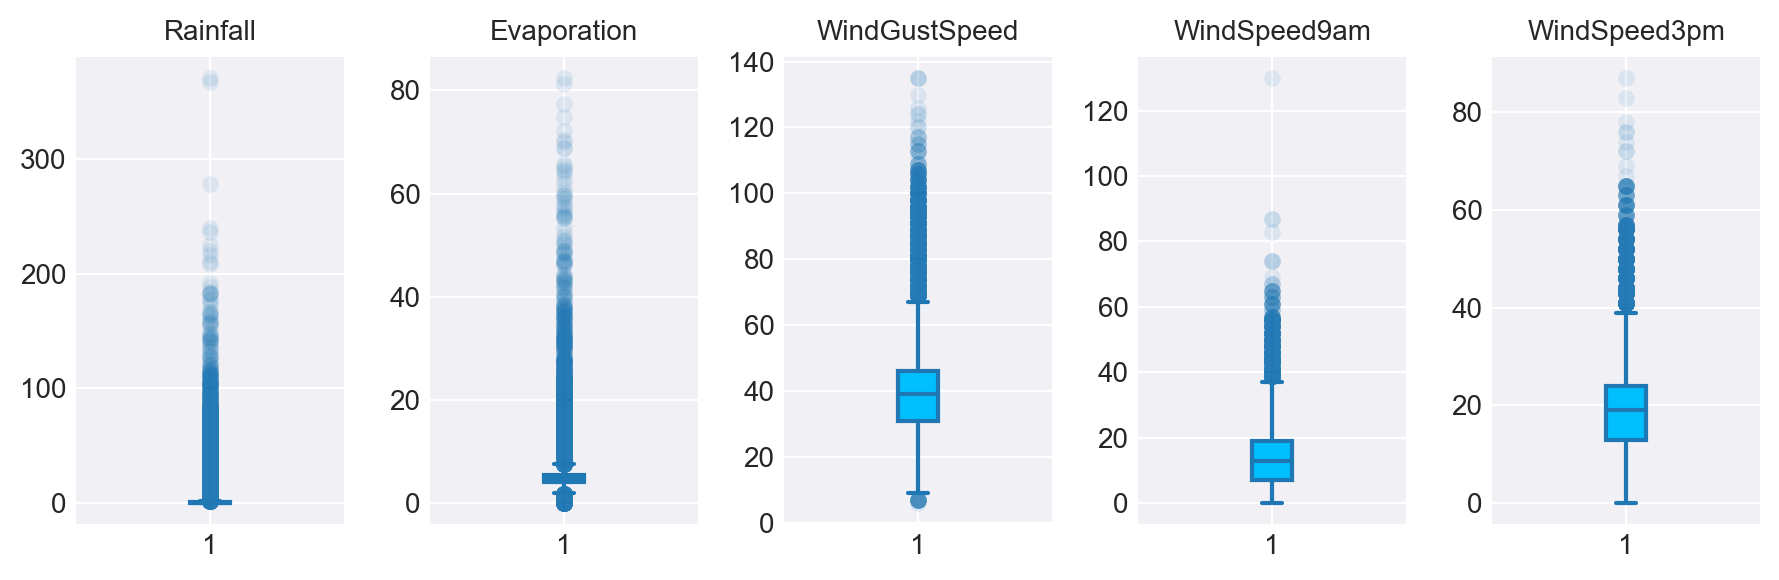

In [107]:
fig, axes = plt.subplots(1,len(outlier_columns), 
                       figsize=(9,3), dpi=200)

set_edgecolor = 'tab:blue'
set_facecolor = 'deepskyblue'
set_lw = 1.5

for order, col_name in enumerate(outlier_columns):
    ax = axes[order]
    ax.boxplot(X_train_raw[col_name], 
               patch_artist=True, widths=0.15,
               boxprops=dict(facecolor=set_facecolor, 
                             edgecolor=set_edgecolor, lw=set_lw),
               medianprops=dict(color=set_edgecolor, lw=set_lw),
               whiskerprops=dict(color=set_edgecolor, lw=set_lw),
               capprops=dict(color=set_edgecolor, lw=set_lw),
               flierprops=dict(markerfacecolor=set_edgecolor,
                               markeredgecolor='none', 
                               alpha=0.1, markersize=6)
                )
    ax.set_title(col_name, fontsize=10)

    # set background whiter
    ax.patch.set_alpha(0.7) 

fig.tight_layout()

I could not find a built in outlier detection & handling pipeline in common python libraries. So, let's write our own functions.  

In [108]:
def DetectOutliers(df, col_name):
    '''
    Detect normal range for a given df and col_name
    using IQR method
    Return lower and upper limit
    '''
    Q3 = df[col_name].quantile(0.75)
    Q1 = df[col_name].quantile(0.25)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    return lower_limit, upper_limit

Should we just remove the outliers? I think, that does not make much sense for our data. We have lots of outliers up to 47% in each feature and we might end up with only a small fraction of the original data if we throw all the outliers in each column.

Some or all of the 5 features that have too many outliers might end up with being very weak predictive features (weakly correlated with *RainTomorrow*) once we train our model. In that situation, we might consider even dropping the entire column(s). But we should first use as much data as possible for training.  

Instead of throwing them, use **top-coding** (cap max. values) to replace outliers with the min, max value from the training set calculated using **IQR method**.

In [109]:
def ReplaceOutliers(df, col_name, lower_limit, upper_limit):
    '''
    Replace outliers with max and min calculated using IQR
    Return modified df
    '''
    df_copy = df.copy()  # do not modify original df
    df_copy.loc[ df_copy[col_name]>upper_limit, col_name ] = upper_limit
    df_copy.loc[ df_copy[col_name]<lower_limit, col_name ] = lower_limit
    
    return df_copy

In [110]:
# Get outliers stats from training set
# Then, replace outliers both in training and test set
for col_name in outlier_columns:
    lower_limit, upper_limit = DetectOutliers(X_train_raw, col_name) 

    X_train_raw = ReplaceOutliers(X_train_raw, col_name, 
                                  lower_limit, upper_limit)
    
    X_test_raw = ReplaceOutliers(X_test_raw, col_name, 
                                 lower_limit, upper_limit)

Box plot after engineering outliers (training set)

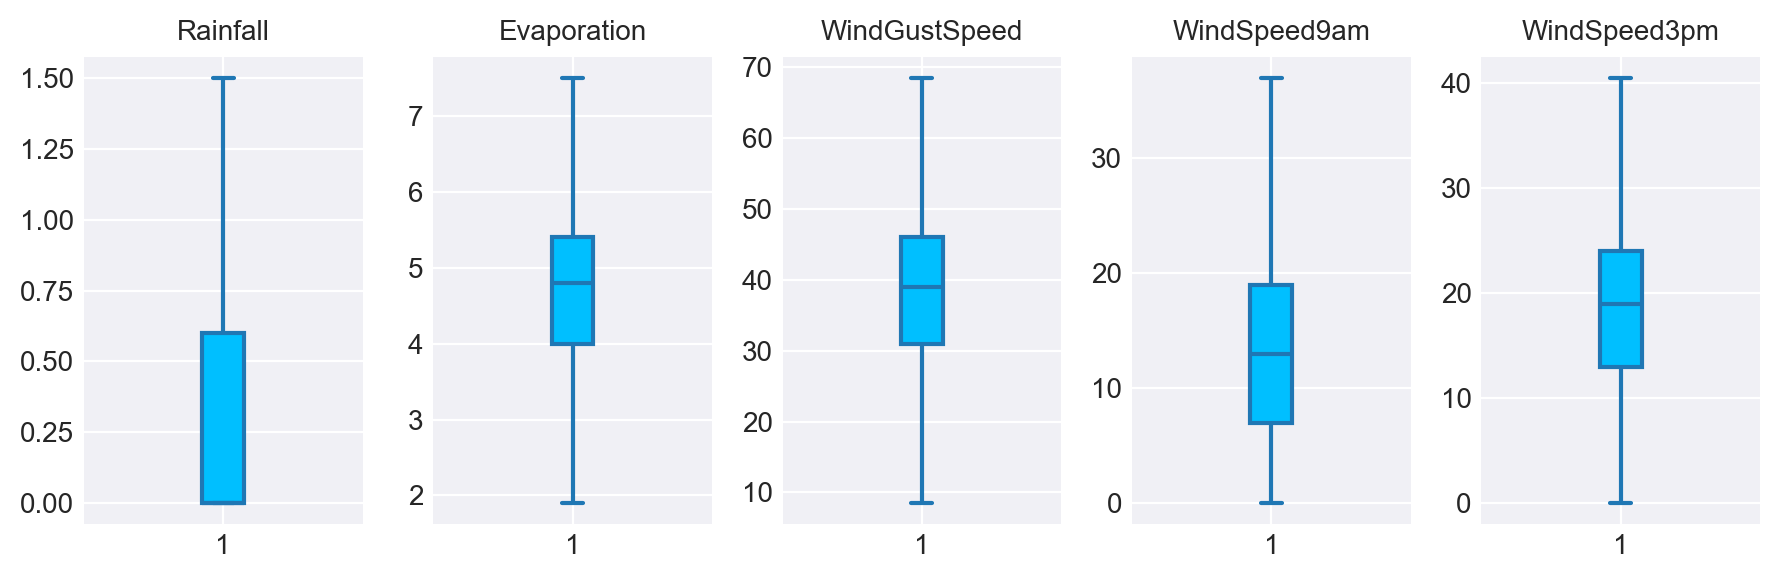

In [111]:
fig, axes = plt.subplots(1,len(outlier_columns), figsize=(9,3), dpi=200)

set_edgecolor = 'tab:blue'
set_facecolor = 'deepskyblue'
set_lw = 1.5

for order, col_name in enumerate(outlier_columns):
    ax = axes[order]
    
    ax.boxplot(X_train_raw[col_name], 
               patch_artist=True, widths=0.15,
               boxprops=dict(facecolor=set_facecolor, 
                             edgecolor=set_edgecolor, lw=set_lw),
               medianprops=dict(color=set_edgecolor, lw=set_lw),
               whiskerprops=dict(color=set_edgecolor, lw=set_lw),
               capprops=dict(color=set_edgecolor, lw=set_lw),
               flierprops=dict(markerfacecolor=set_edgecolor,
                               markeredgecolor='none', 
                               alpha=0.1, markersize=6) )
    
    ax.set_title(col_name, fontsize=10)
    
    # set background whiter
    ax.patch.set_alpha(0.7)

fig.tight_layout()

All outliers are gone &#128077;

## One-Hot Encoding 

In [112]:
categorical_cols

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [113]:
X_train_raw

,Location,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,Year,Month,Day
18888,NorahHead,1.5,4.8,8.5,S,61.0,SSW,SSW,22.0,35.0,...,87.0,1017.5,5.0,5.0,20.8,22.3,Yes,2011.0,2.0,13.0
26385,Penrith,0.0,4.8,8.5,WSW,28.0,NE,WNW,4.0,17.0,...,32.0,1015.3,5.0,5.0,15.6,20.3,No,2015.0,5.0,6.0
78164,Watsonia,1.5,2.6,3.8,N,37.0,NNE,N,7.0,13.0,...,85.0,1010.3,7.0,7.0,3.3,12.0,Yes,2009.0,6.0,25.0
112230,Witchcliffe,1.5,4.8,8.5,S,46.0,SSE,SSE,19.0,15.0,...,85.0,1023.7,5.0,5.0,11.4,10.2,Yes,2010.0,9.0,12.0
142318,Katherine,0.0,6.0,8.5,E,68.5,WNW,W,20.0,11.0,...,47.0,1007.2,6.0,2.0,29.5,36.2,No,2013.0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92231,GoldCoast,0.0,4.8,8.5,SSE,54.0,SSE,SSE,35.0,40.5,...,61.0,1023.3,5.0,5.0,17.6,18.8,No,2014.0,8.0,12.0
102321,MountGambier,0.0,4.8,8.5,W,44.0,W,NW,20.0,26.0,...,77.0,1010.6,8.0,8.0,13.4,16.6,No,2016.0,11.0,6.0
106071,Woomera,0.0,2.2,6.4,W,57.0,WSW,SW,30.0,30.0,...,59.0,1009.4,6.0,6.0,14.1,17.6,No,2010.0,5.0,25.0
113455,Witchcliffe,0.2,4.8,8.5,WSW,24.0,ESE,WSW,6.0,13.0,...,57.0,1020.1,5.0,5.0,14.2,21.5,No,2014.0,4.0,18.0


For a given feature some labels in the test set might not be present in training set. This is more likely for smaller data sets. To avoid this, explicitly provide all possible categories for a given label to the `OneHotEncoder` object.

In [114]:
# Obtain all possible categories for each feature
# from original df, not from X_train_raw
ohe_categories = []

for col_name in categorical_cols:
    ohe_categories.append(df[col_name].dropna().unique())

ohe_categories

[array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
        'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
        'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
        'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
        'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
        'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
        'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
        'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
        'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
        'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object),
 array(['W', 'WNW', 'WSW', 'NE', 'NNW', 'N', 'NNE', 'SW', 'ENE', 'SSE',
        'S', 'NW', 'SE', 'ESE', 'E', 'SSW'], dtype=object),
 array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', 'SSW', 'N', 'WSW',
        'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object),
 array(['WNW', 'WSW'

In [115]:
# Set sparse_output to False, so that the encoder returns array
# instead of a sparse matrix
encoder = OneHotEncoder(sparse_output= False, 
                        categories= ohe_categories, 
                        drop= 'if_binary' # drop one of cols if binary 
                        )

*"Dropping one column during one hot encoding is useful in situations where perfectly collinear features cause problems, such as when feeding the resulting data into an unregularized linear regression model.*

*However, dropping one category breaks the symmetry of the original representation and can therefore induce a bias in downstream models, for instance for penalized linear classification or regression models."*

Since the models we will be using are complex models, I think it's better not to drop any cols except the binary *RainToday* col. I'm guessing it might be also a problem for feature importance attributed to *RainToday*.


In [116]:
# transform categorical cols and leave numerical cols untouched
ohe_transformer = ColumnTransformer(
    transformers= [("ohe", encoder, categorical_cols)],
    remainder= "passthrough" )

ohe_transformer.set_output(transform= "pandas")
# "ohe" in the transformers stands for the prefix
# to be added to the original col names

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 OneHotEncoder(categories=[array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'Melb...
                                                           array(['W', 'NNW', 'SE', 'ENE', 'SW', 'SSE', 'S', 'NE', 'SSW', 'N', 'WSW',
       'ESE', 'E', 'NW', 'WNW', 'NNE'], dtype=object),
                                                           array(['WNW', 'WSW', 'E', 'NW', 'W', 'SSE', 'ESE', 'ENE', 'NNW', 'SSW',
       'SW', 'SE', 'N', 'S', 'NNE', 'NE'], dtype=object),
                                                           array(['No', 'Yes'], dtype=object)],
                                               drop='if_binary',
                                               sparse_output=False),
                                 ['Location', 'WindGustDir', 'WindDir9am',
                                  'WindDir3pm', 'RainToday'])])

In [117]:
X_train_enc = ohe_transformer.fit_transform(X_train_raw)

X_train_enc

,ohe__Location_Albury,ohe__Location_BadgerysCreek,ohe__Location_Cobar,ohe__Location_CoffsHarbour,ohe__Location_Moree,ohe__Location_Newcastle,ohe__Location_NorahHead,ohe__Location_NorfolkIsland,ohe__Location_Penrith,ohe__Location_Richmond,...,remainder__Humidity9am,remainder__Humidity3pm,remainder__Pressure3pm,remainder__Cloud9am,remainder__Cloud3pm,remainder__Temp9am,remainder__Temp3pm,remainder__Year,remainder__Month,remainder__Day
18888,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,89.0,87.0,1017.5,5.0,5.0,20.8,22.3,2011.0,2.0,13.0
26385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,43.0,32.0,1015.3,5.0,5.0,15.6,20.3,2015.0,5.0,6.0
78164,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,85.0,1010.3,7.0,7.0,3.3,12.0,2009.0,6.0,25.0
112230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,66.0,85.0,1023.7,5.0,5.0,11.4,10.2,2010.0,9.0,12.0
142318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,77.0,47.0,1007.2,6.0,2.0,29.5,36.2,2013.0,3.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,62.0,61.0,1023.3,5.0,5.0,17.6,18.8,2014.0,8.0,12.0
102321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,81.0,77.0,1010.6,8.0,8.0,13.4,16.6,2016.0,11.0,6.0
106071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,80.0,59.0,1009.4,6.0,6.0,14.1,17.6,2010.0,5.0,25.0
113455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,95.0,57.0,1020.1,5.0,5.0,14.2,21.5,2014.0,4.0,18.0


In [118]:
X_test_enc = ohe_transformer.transform(X_test_raw)

X_test_enc

,ohe__Location_Albury,ohe__Location_BadgerysCreek,ohe__Location_Cobar,ohe__Location_CoffsHarbour,ohe__Location_Moree,ohe__Location_Newcastle,ohe__Location_NorahHead,ohe__Location_NorfolkIsland,ohe__Location_Penrith,ohe__Location_Richmond,...,remainder__Humidity9am,remainder__Humidity3pm,remainder__Pressure3pm,remainder__Cloud9am,remainder__Cloud3pm,remainder__Temp9am,remainder__Temp3pm,remainder__Year,remainder__Month,remainder__Day
128779,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,90.0,56.0,1026.5,5.0,5.0,11.7,15.4,2014.0,8.0,2.0
28110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,80.0,56.0,1021.5,5.0,5.0,15.7,20.2,2011.0,9.0,1.0
112568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.0,63.0,1016.2,5.0,5.0,15.2,17.4,2011.0,9.0,15.0
22732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,79.0,48.0,1020.9,7.0,2.0,13.0,16.4,2013.0,8.0,30.0
73008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,98.0,60.0,1015.2,8.0,5.0,9.2,14.7,2016.0,5.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16550,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,86.0,53.0,1015.3,1.0,5.0,21.0,27.5,2013.0,3.0,13.0
52303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,86.0,52.0,1015.3,5.0,5.0,-1.2,21.1,2009.0,7.0,30.0
85065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,45.0,1023.0,1.0,2.0,13.6,23.0,2011.0,6.0,24.0
107211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,2.0,1010.0,0.0,5.0,24.1,33.0,2013.0,10.0,5.0


*X_train_raw / X_test_raw* had 24 cols and now encoded versions have 114 cols.

## Feature Scaling

As the last step before training my model, I need to scale features. Scaling is almost always a good practice as some models do not work or work slower on unscaled data (takes longer time to converge a solution). 

I will use **min-max scaler** to scale all features between 0-1. Min-max scaler is also better than mean scaler as it leaves one-hot encoded values as are since they are already between 0-1.   

In [119]:
# Before scaling
X_train_enc.describe()

,ohe__Location_Albury,ohe__Location_BadgerysCreek,ohe__Location_Cobar,ohe__Location_CoffsHarbour,ohe__Location_Moree,ohe__Location_Newcastle,ohe__Location_NorahHead,ohe__Location_NorfolkIsland,ohe__Location_Penrith,ohe__Location_Richmond,...,remainder__Humidity9am,remainder__Humidity3pm,remainder__Pressure3pm,remainder__Cloud9am,remainder__Cloud3pm,remainder__Temp9am,remainder__Temp3pm,remainder__Year,remainder__Month,remainder__Day
count,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,...,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000
mean,0.021206,0.020925,0.020520,0.020705,0.020072,0.020696,0.020538,0.021022,0.020846,0.020855,...,68.882856,51.470222,1015.268061,4.648989,4.700536,16.977653,21.673352,2012.751961,6.409416,15.707280
std,0.144072,0.143134,0.141773,0.142396,0.140248,0.142366,0.141832,0.143457,0.142869,0.142898,...,18.941512,20.527065,6.681681,2.294598,2.119080,6.466948,6.868091,2.541889,3.425200,8.802952
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2007.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,57.000000,37.000000,1011.000000,3.000000,4.000000,12.300000,16.700000,2011.000000,3.000000,8.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,70.000000,52.000000,1015.300000,5.000000,5.000000,16.700000,21.100000,2013.000000,6.000000,16.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,83.000000,65.000000,1019.400000,6.000000,6.000000,21.500000,26.300000,2015.000000,9.000000,23.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,100.000000,100.000000,1039.600000,8.000000,9.000000,40.200000,46.700000,2017.000000,12.000000,31.000000


In [120]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(
            data= scaler.fit_transform(X_train_enc),
            columns= X_train_enc.columns,
            index= X_train_enc.index)

X_test = pd.DataFrame(
            data= scaler.transform(X_test_enc),
            columns= X_test_enc.columns,
            index= X_test_enc.index)

# After scaling
X_train.describe()

,ohe__Location_Albury,ohe__Location_BadgerysCreek,ohe__Location_Cobar,ohe__Location_CoffsHarbour,ohe__Location_Moree,ohe__Location_Newcastle,ohe__Location_NorahHead,ohe__Location_NorfolkIsland,ohe__Location_Penrith,ohe__Location_Richmond,...,remainder__Humidity9am,remainder__Humidity3pm,remainder__Pressure3pm,remainder__Cloud9am,remainder__Cloud3pm,remainder__Temp9am,remainder__Temp3pm,remainder__Year,remainder__Month,remainder__Day
count,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,...,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000,113740.000000
mean,0.021206,0.020925,0.020520,0.020705,0.020072,0.020696,0.020538,0.021022,0.020846,0.020855,...,0.688829,0.514702,0.610689,0.581124,0.522282,0.510077,0.519642,0.575196,0.491765,0.490243
std,0.144072,0.143134,0.141773,0.142396,0.140248,0.142366,0.141832,0.143457,0.142869,0.142898,...,0.189415,0.205271,0.106907,0.286825,0.235453,0.136434,0.131825,0.254189,0.311382,0.293432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.570000,0.370000,0.542400,0.375000,0.444444,0.411392,0.424184,0.400000,0.181818,0.233333
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.700000,0.520000,0.611200,0.625000,0.555556,0.504219,0.508637,0.600000,0.454545,0.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.830000,0.650000,0.676800,0.750000,0.666667,0.605485,0.608445,0.800000,0.727273,0.733333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Balancing Data (Oversampling, SMOTE, etc.)?

We have somewhat imbalanced target variable, the ratio of No : Yes is about 1 : 3.5. That is not heavily skewed though. Balancing data is usually implemented when the imbalance ratio is much higher e.g. 1:100, 1:1000.. like in detecting credit card fraud or catching a very rare disease. Most widely used data balancing techniques are **random oversampling minority class** (basically randomly duplicating samples belonging to minority class), random undersampling majority class (randomly discarding some samples belonging to majority class) or resampling combined with data augmentation such as ***SMOTE (Synthetic Minority Oversampling Technique)***. There are some downsides of balancing data though.

*"... in random under-sampling (potentially), vast quantities of data are discarded. [...] This can be highly problematic, as the loss of such data can make the decision boundary between minority and majority instances harder to learn, resulting in a loss in classification performance."*

*"That’s what the authors of the paper To SMOTE, or not to SMOTE? found out: SMOTE works, but only for weak learners, and if you use measures such as AUC and don’t care about calibration. SMOTE didn’t improve performance for strong classifiers. Don’t use SMOTE if you use state-of-the-art classifiers"* ([source](https://mindfulmodeler.substack.com/p/dont-fix-your-imbalanced-data))

I will use oversampling of the minority class to give it a try to see if it gives better performance for the models. It is very easy to implement.

In [121]:
# over sample train set only, no need to oversample test set
oversampler = RandomOverSampler(random_state= random_state)

X_train_oversampled, y_train_oversampled = oversampler.fit_resample(
                                                X_train, y_train)

In [122]:
y_train.value_counts()

0.0    88258
1.0    25482
Name: RainTomorrow, dtype: int64

Original train set has imbalanced classes.

In [64]:
y_train_oversampled.value_counts()

1.0    88258
0.0    88258
Name: RainTomorrow, dtype: int64

Oversampled train set has equal number of samples from each class.

# TRAINING - LOGISTIC REGRESSION

Set near-default parameters for logistic regression

In [123]:
logreg_near_default_params= {
                            'solver': 'liblinear',
                            'penalty': 'l2',
                            'C': 1,
                            'random_state': random_state,
                            'max_iter': 100,
                            }

In [124]:
logreg = LogisticRegression(**logreg_near_default_params)

# fit
logreg.fit(X_train, y_train)

LogisticRegression(C=1, random_state=777, solver='liblinear')

## Model Evaluation

### Accuracy and F1-Score

In [126]:
def print_accuracy_f1_score(model):
    '''
    Print model accuracy and f1-score
    on training and test set
    '''
    # predict train
    y_pred_train = model.predict(X_train)
    # predict test
    y_pred_test = model.predict(X_test)

    # in keras, model.predict(...) returns probs not labels
    if 'keras' in model.__module__:
        threshold = 0.5
        y_pred_train = (y_pred_train > threshold).astype(int)
        y_pred_test = (y_pred_test > threshold).astype(int)

    # accuracy
    train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
    test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
    print(f'Train accuracy: {train_accuracy:.2f}')
    print(f'Test accuracy: {test_accuracy:.2f}')
    
    print ()    

    # f1-score
    train_f1_score = metrics.f1_score(y_train, y_pred_train)
    test_f1_score = metrics.f1_score(y_test, y_pred_test)
    print(f'Train F1-score: {train_f1_score:.2f}')
    print(f'Test F1-score: {test_f1_score:.2f}') 

In [127]:
print_accuracy_f1_score(logreg)

Train accuracy: 0.85
Test accuracy: 0.85

Train F1-score: 0.60
Test F1-score: 0.60


<u>Comments</u>:
- Accuracy looking good, no gap between the train and test set accuracy meaning no sign of overfitting

- F1-score is a better metric than accuracy to asses the model performance as it combines precision and recall. It looks little low. Can we do better?

- What is our reference to assess the significance of our accuracy? The first reference is the ***null accuracy***, the accuracy obtained when always predicting most frequent class. If we always predict NO rain we would actually still get a decent accuracy.

In [128]:
y_test.value_counts(normalize=True)

0.0    0.775243
1.0    0.224757
Name: RainTomorrow, dtype: float64

We see that always predicting NO rain would yield accuracy of 0.77 which is the null accuracy of our dataset. Our model had 0.84 accuracy. Can we do even better?   

Print more evaluation metrics: precision, recall..

In [129]:
# more details (precision, recall...) on test set
y_pred_test = logreg.predict(X_test)

print(metrics.classification_report(y_test, y_pred_test,
                                    target_names= ['No','Yes']))

              precision    recall  f1-score   support

          No       0.87      0.94      0.90     22058
         Yes       0.72      0.51      0.60      6395

    accuracy                           0.85     28453
   macro avg       0.80      0.73      0.75     28453
weighted avg       0.84      0.85      0.84     28453



### Confusion Matrix

In [134]:
def plot_confusion_matrix(model):
    '''
    Plot confusion matrix of the model
    '''
    y_pred_test = model.predict(X_test)

    # in keras, model.predict(...) returns probs not labels
    if 'keras' in model.__module__:
        threshold = 0.5
        y_pred_test = (y_pred_test > threshold).astype(int)
    
    cmat_data = metrics.confusion_matrix(y_test, y_pred_test)
    # Confusion matrix whose i-th row and j-th column entry
    # indicates number of samples with true label being i-th class
    # and predicted label being j-th class.    

    fig, ax = plt.subplots(figsize=(3,3), dpi=150)

    sns.heatmap(data=cmat_data, 
                xticklabels=['No', 'Yes'], 
                yticklabels=['No', 'Yes'],
                ax=ax, cbar=False, annot=True,
                fmt='d', cmap='Blues_r', lw=1.0)

    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    #ax.set_title('Confusion Matrix', fontsize=15)

    # do not rotate y-axis tick labels
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    fig.tight_layout()
    fig.savefig('Figures/confusion_matrix.jpg', dpi=500)

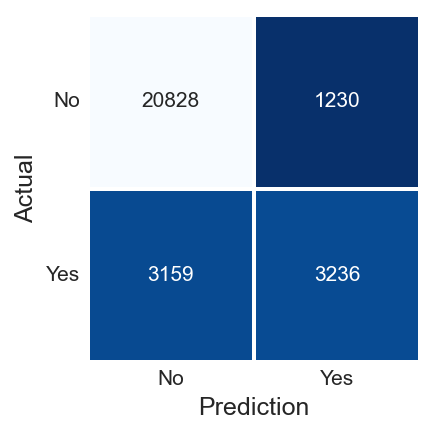

In [135]:
plot_confusion_matrix(logreg)

<u>Comments</u>
- As expected, we have lots of true negatives

- At a first glance, incorrectly classified label counts (off-diagonal elements: FP and FN) are comparable to one of the main diagonal elements (TP). Absolute values in the confusion matrix are not ideal way to asses the performance of the model. Rather, fractional metrics such as specificity, precision, recall are better to look at.

### ROC Curve

In [136]:
# Predict prob. of test set belonging to each category
logreg.predict_proba(X_test)

array([[0.77875228, 0.22124772],
       [0.92086851, 0.07913149],
       [0.5469928 , 0.4530072 ],
       ...,
       [0.98289892, 0.01710108],
       [0.98796633, 0.01203367],
       [0.49154837, 0.50845163]])

In [137]:
def plot_ROC_curve(model):
    '''
    Plots ROC curve of the model
    '''
    # if sklearn model
    if 'sklearn' in model.__module__:
        # predict prob. of test set belonging to each category
        # first col of predict_proba method is probs of label "No"
        # thus select the second col
        y_probs_test = model.predict_proba(X_test)[:,1]

    # in keras, model.predict(...) returns probs not labels
    if 'keras' in model.__module__:
        y_probs_test = model.predict(X_test)

    # roc_curve returns:
    # false pos rates, true positive rates and thresholds     
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs_test)
    # returns decreasing threshold

    # plot
    fig, ax = plt.subplots(figsize=(4,3.2), dpi=150)

    # random classifier 
    ax.plot([0,1], [0,1], lw=2.0, ls='--', 
            color='tab:orange', label='random classifier')

    # perfect classifier
    ax.plot([0,0,1], [0,1,1], lw=2.0, ls=':', 
            color='tab:red', label='perfect classifier')

    # explicitly mark the perfect spot
    ax.scatter(0, 1, s=30, c='tab:red')

    # annotate perfect spot
    ax.annotate('perfect', xy=(0.03, 0.96), 
                xycoords='data', fontsize=8, 
                ha='left', va='top')

    # roc curve
    ax.plot(fpr, tpr, lw= 2.0, 
            color= 'tab:blue', 
            label= model.__class__.__name__)

    # explicitly mark the point with threshold=0.5
    # index of the first element in thresholds smaller than 0.5
    ind_half =  np.argmax(thresholds<0.5)
    fpr_half =  fpr[ind_half]
    tpr_half = tpr[ind_half]
    ax.scatter(fpr_half, tpr_half, s=40, c='tab:blue')

    # annotate threshold=0.5
    ax.annotate(f'TPR: {tpr_half:.2f}\nFPR: {fpr_half:.2f}', 
                xy=(fpr[ind_half]+0.23, tpr[ind_half]), 
                xycoords='data', fontsize=8, 
                ha='right', va='center')

    # calculate roc-auc score
    model_auc_score = metrics.roc_auc_score(y_test, y_probs_test)
    ax.set_title(f'ROC – AUC score: {model_auc_score:.2f}', 
                 fontsize=10)

    ax.set_xlabel('False positive rate \n(1 - Specificity)')
    ax.set_ylabel('True positive rate \n(Sensitivity)')
    ax.legend(fontsize=9, labelcolor='linecolor')

    # set background whiter
    ax.patch.set_alpha(0.7)

    fig.tight_layout()
    fig.savefig('Figures/ROC_AUC_curve.jpg', dpi=500)

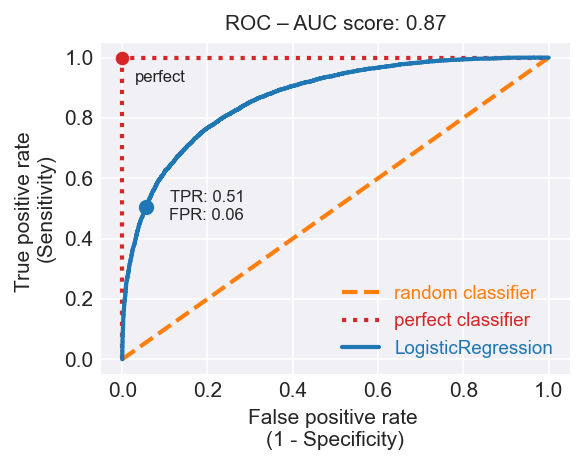

In [138]:
plot_ROC_curve(logreg)

<u>Comments</u>
- Closer the ROC curve to the perfect classifier the better the model is

- AUC score is between 0-1 where the ideal classifier has 1.0 and random classifier has 0.5 and totally reverse classifier is 0.

- Our model seems to be doing ok

- We used the default threshold value of 0.5 in classification when we did logreg.predict(...). We can further play with threshold to optimize the desired metric which ultimately depends on what we want from the model i.e. do we want to minimize false positives or false negatives?

- At threshold=0.5, FPR is only 0.06 which is seemingly pretty good. This is probably because we have too many true negatives as a natural consequence of having imbalanced data. That is why FPR, hence ROC curve, is not a good metric in the case of an imbalanced data.

- At threshold=0.5, TPR is 0.51 which is not that good. It indicates there is rooom for improvement.

It is known that ROC curves present an optimistic picture of the model on datasets with a class imbalance. More explicitly, if the proportion of positive to negative instances changes in a test set, the ROC curves will not change. Thus, we might want to look at precision-recall curve as well to further assess the performance of our model.  

### Precision-Recall Curve

Precision-Recall curves should be used when there is a moderate to large class imbalance whereas ROC curves are most useful when there are roughly equal numbers of observations for each class. The key to the calculation of precision and recall is that the calculations do not make use of the true negatives which is NO-rain in our case. It is only concerned with the correct prediction of the minority class: YES-rain. 

In [139]:
def plot_precision_recall_curve(model):
    '''
    Plots precision-recall curve of the model
    '''

    # if sklearn model
    if 'sklearn' in model.__module__:
        # predict prob. of test set belonging to each category
        # first col of predict_proba method is probs of label "No"
        # thus select the second col
        y_probs_test = model.predict_proba(X_test)[:,1]

    # in keras, model.predict(...) returns probs not labels
    if 'keras' in model.__module__:
        y_probs_test = model.predict(X_test)

    # calculate precision and recall pairs at various threshold levels 
    precisions, recalls, thresholds = metrics.precision_recall_curve(
                                                y_test, y_probs_test)  
    # returns increasing thresholds

    # plot
    fig, ax = plt.subplots(figsize=(4,3), dpi=150)

    # random classifier 
    random_precision = y_test.value_counts(normalize=True)[1.0]
    ax.plot([0,1], [random_precision, random_precision], 
            lw=2.0, ls='--', color='tab:orange', 
            label='random classifier')

    # perfect classifier
    ax.plot([0,1,1], [1,1,random_precision], 
            lw=2.0, ls=':', color='tab:red', 
            label='perfect classifier')

    # explicitly mark the perfect spot
    ax.scatter(1, 1, s=30, c='tab:red')

    # annotate perfect spot
    ax.annotate('perfect', xy=(0.92, 0.96), 
                xycoords='data', fontsize=8, 
                ha='center', va='top')

    # precision-recall curve
    ax.plot(recalls, precisions,  
            color= 'tab:blue', lw=2.0,
            label= model.__class__.__name__)

    # explicitly mark the point with threshold=0.5 on the curve
    # index of the first element in thresholds larger than 0.5
    ind_half =  np.argmax(thresholds>0.5)
    ax.scatter(recalls[ind_half], precisions[ind_half], s=40)

    # annotate threshold=0.5
    recall_half = recalls[ind_half]
    precision_half = precisions[ind_half]
    ax.annotate(f'precision: {precision_half:.2f}\nrecall: {recall_half:.2f}',
                xy=(recall_half+0.25, precision_half), 
                xycoords='data', fontsize=8, 
                ha='right', va='bottom')

    ax.set_xlabel('Recall (Sensitivity)')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve', fontsize=10)
    ax.legend(bbox_to_anchor=(0.5, 0.15), fontsize=9, 
              labelcolor='linecolor')

    # set background whiter
    ax.patch.set_alpha(0.7)

    fig.tight_layout()
    fig.savefig('Figures/precision_recall_curve.jpg', dpi=500)

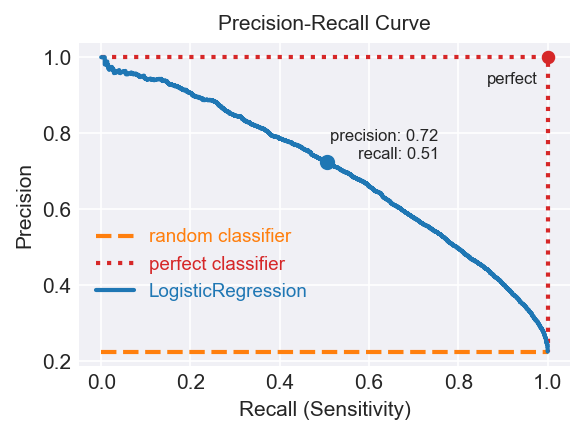

In [140]:
plot_precision_recall_curve(logreg)

<u>Comments</u>
- Precision-recall curve reflects the model performance better than ROC curve for this dataset. 

- Recall (sensitivity or TPR) is already a shared metric between the two curves. Here, there is precision instead of false positive rate in ROC curve. Since false positive rate has total number of negative samples in the denominator and we have lots of negatives it leads to overly-optimistic value for FPR=0.06 (or specificity=0.94) at threshold=0.5 in ROC curve. Here, precision=0.71 at cutoff=0.5 is a more realistic metric for the model performance.

### Feature Importance - Permutation

We assessed the model performance using various metrics. During EDA, we used PPS matrix to get a sense of which features might be potentially important in predicting *RainTomorrow*. Now, we are wondering which features really turned out to be important for our model. For this, we will use `permutation_importance` method from `sklearn` library. 

*"The permutation method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one. The permutation based importance is computationally expensive."*

*"The permutation based method can have problem with highly-correlated features. When features are collinear, permuting one feature has little effect on the models performance because it can get the same information from a correlated feature. This will result in a lower importance value for both features, where they might actually be important."*

In [141]:
def plot_permutation_importance(model, frac_samples= 1.0, highest_N= 10):
    '''
    Calculates permutation feature importances
    Considers fraction of test set frac_samples <= 1.0
    Plots highest_N features
    Permutation importance works for sklearn models,
    not for ANN (Keras models)
    '''

    # Calculate feature importance for test set
    imp_report = permutation_importance(model, 
                                        X_test, y_test,
                                        max_samples= frac_samples)

    # Create a series and sort by importance
    importances = pd.Series(data= imp_report.importances_mean, 
                            index= model.feature_names_in_)
    importances.sort_values(ascending=False, inplace=True)

    # Strip prefix "ohe__" or "remainder__" from feature names
    importances.index = importances.index.map(lambda x: x.split('__')[1])


    # Plot
    fig, ax = plt.subplots(figsize=(4,3), dpi=150)

    ax.barh(y = importances.iloc[highest_N::-1].index, 
            width = importances.iloc[highest_N::-1].values,
            color='tab:blue')

    ax.tick_params(axis='both', labelsize=7)
    ax.set_title('Permutation Feature Importance', 
                 fontweight='bold')

    # Set background whiter
    ax.patch.set_alpha(0.6)

    fig.tight_layout()
    fig.savefig('Figures/feature_importance_permutation.jpg', dpi=500)

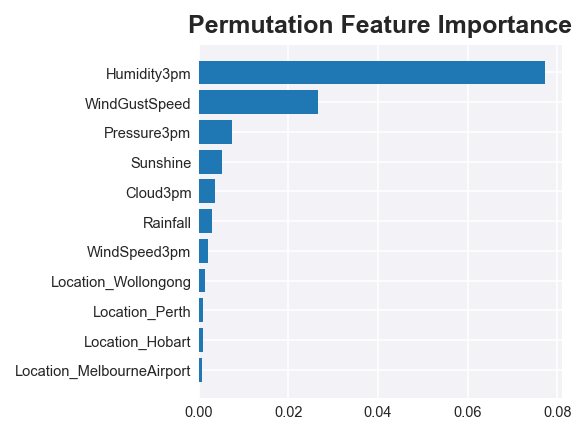

In [143]:
plot_permutation_importance(logreg, frac_samples= 1.0)

<u>Comments</u>
- *Humidity3pm* turned out to be the most important feature to predict *RainTomorrow* (it had the highest PPS too)

- The next most important features *WindGustSpeed*, *Pressure3pm*,  *Sunshine* and *Cloud3pm* which were already proposed to have high predictive score in PPS plot. 

- Sklearn doc says *"...permutation importance does not reflect the intrinsic predictive value of a feature by itself but how important this feature is for a particular model. Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model."* However, since our model is performing well, permutation importance should converge to PPS.

### Feature Importance - SHAP

- One of the useful things about SHAP plots is that they assign a contribution score to each feature, indicating how much each feature influenced the model's prediction <u>for a specific data point</u>. SHAP values provide insights at an individual prediction level. This means you can see how each feature contributes to a specific prediction, not just to overall model behavior.

- SHAP values are consistent with some of the most commonly used feature importance techniques, such as permutation importance

- SHAP values are model-agnostic, meaning you can use them with various machine learning algorithms, including linear regression, decision trees, random forests, gradient boosting, and deep learning models ([more info](https://christophm.github.io/interpretable-ml-book/shapley.html) and [examples](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)).

Beeswarm plot: plot every data point with SHAP feature values

In [159]:
def plot_shap_beeswarm(model, frac_samples= 0.01, highest_N= 10):
    '''
    Plots beeswarm plot from shap library
    Consideres a fraction of test set frac_samples <= 1
    SHAP for ANN is too slow, so choose frac_samples ~ 0.01
    Display highest_N features
    '''

    # fraction of the test set for SHAP calculation
    X_frac_test = X_test.sample(frac= frac_samples)
    
    # calculate shap values
    explainer = shap.Explainer(model.predict, 
                               X_frac_test, silent= True)       
    shap_values = explainer(X_frac_test)

    # remove prefix "ohe__" or "remainder__" 
    # from feature names for better plot display
    shap_values.feature_names = [x.split('__')[1] for x 
                                 in shap_values.feature_names]


    # default mpl style is better for this plot
    plt.style.use('default')

    shap.plots.beeswarm(shap_values, show=False, 
                        max_display=highest_N)

    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(8,4)
    fig.set_dpi(100)

    ax.tick_params(axis='both', labelsize=11)

    # set height:width aspect ratio of colorbar
    fig.axes[-1].set_aspect(50)

    fig.tight_layout()
    fig.savefig('Figures/feature_importance_beeswarm.jpg', dpi=500)

    # go back to style of choice
    plt.style.use(plotting_style)

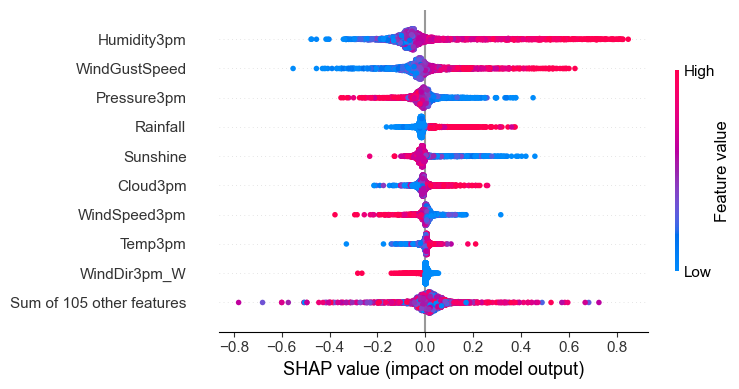

In [156]:
plot_shap_beeswarm(logreg, frac_samples= 0.1)

Plot mean absolute importance of features - similar to permutation importance

In [160]:
def plot_shap_importance(model, frac_samples= 0.01, highest_N= 10):
    '''
    Plots mean absolute importance of shap values
    Consideres only a fraction of test set frac_samples <= 1
    SHAP for ANN is too slow, so choose frac_samples ~ 0.01
    Display highest_N features
    '''

    # Fraction of test set for SHAP calculation
    X_frac_test = X_test.sample(frac= frac_samples)
    
    # Calculate shap values
    explainer = shap.Explainer(model.predict, 
                               X_frac_test, silent= True)       
    shap_values = explainer(X_frac_test)

    # Remove prefix "ohe__" or "remainder__" from 
    # Feature names for better plot display
    shap_values.feature_names = [x.split('__')[1] for x in 
                                 shap_values.feature_names]

    # First take absolute value and then mean over samples
    shap_importance = shap_values.abs.mean(axis=0).values

    # For random forest model, shap produces 
    # 2-dimensional shap_importance for some reason
    # so, use the first col
    if shap_importance.ndim == 2:
        shap_importance = shap_importance[:,0]
    
    # Create a series and sort by importance
    importances = pd.Series(data = shap_importance, 
                            index = shap_values.feature_names)
    importances.sort_values(ascending=False, inplace=True) 


    # Plot
    fig, ax = plt.subplots(figsize=(4,3), dpi=150)

    ax.barh(y = importances.iloc[highest_N::-1].index, 
            width = importances.iloc[highest_N::-1].values,
            color='tab:green')

    ax.tick_params(axis='both', labelsize=7)
    ax.set_title('SHAP Feature Importance', 
                 fontweight='bold')

    # set background whiter
    ax.patch.set_alpha(0.6)

    fig.tight_layout()
    fig.savefig('Figures/feature_importance_shap.jpg', dpi=500)

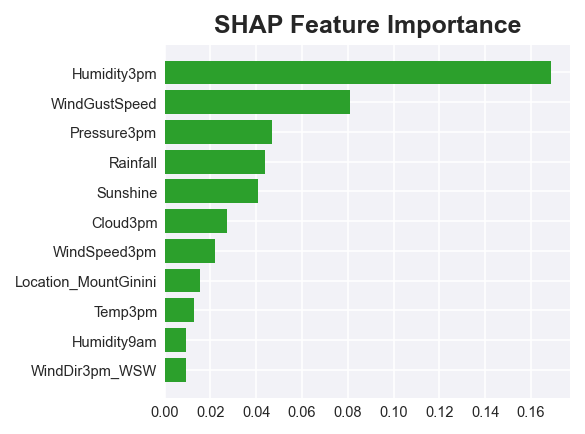

In [161]:
plot_shap_importance(logreg, frac_samples= 0.1)

<u>Comments</u>
- SHAP and feature importances from sklearn pretty similar: order of the most important 7 features are very similar. We are now confident that these are indeed the most important features for the current model. Next thing to do: can we improve the model?  

<b>SHAP vs. Permutation Importance</b>: 

Although SHAP and permutation importance are interchangibly used by ML community, there are some underlying differences in their interpretation. First of all, SHAP is useful to inspect how model behaves or how predictions are affected by the features. So in a sense, SHAP is NOT concerned about the actual performance of the model, rather, **how much features change the behavior of the model**. SHAP answer "why" the prediction is different than the mean prediction and how much each feature contributes to that. On the other hand, permutation importance is more concerned about **how much a feature contributes to the correct predicitions of the model**. This fundemental difference is also evident from that SHAP does not take true labels as input e.g. `shap.Explainer(model, X_test)`, whereas permutation importance does take true labels as input e.g. `permutation_importance(model, X_test, y_test)`.

To illustrate the difference, consider a totally simulated data (no relation between the features and the target variable), SHAP can still produce non-trivial importance values for some features implying some relation between the target variable and the features. On the other hand, permutation importance for all features will be very close to zero since none of the features actually makes a significant difference in correctly predicting the target variable ([source](https://mindfulmodeler.substack.com/p/shap-is-not-all-you-need)).

# TRAINING - XGBOOST

Important parameters:
- <b>max_depth</b> (default: 6, typical: 3-10): deeper trees can model more complex relationships, but as we go deeper, splits become less relevant

- <b>min_child_weight</b> (default: 1, typical: 1-10): smaller value allows the algo to create children corresponding to fewer samples, thus allowing for more complex trees, but more likely to overfit. It is important to tune max_depth and min_child_weight together in order to find a good trade-off between model bias and variance

- <b>subsample</b> (default: 1, typical: 0.5-1): corresponds to the fraction of observations to subsample at each step. By default it is set to 1 meaning that we use all rows.

- <b>colsample_bytree</b> (default: 1, typical: 0.5-1): corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

- <b>learning_rate</b> (default: 0.3, typical: 0.01-0.3): corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step (remember how each boosting round is correcting the errors of the previous?). In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. Lower eta takes more time.

- <b>n_estimators</b> (default: 100, typical: 100-1000): controls the number of trees in the model. Increasing this value generally improves model performance, but can also lead to overfitting. Typically between 100-1000.

Use usual (near-default) params for now. Tune them later. 

In [162]:
xgb_near_default_params= {
                        'learning_rate': 0.05,
                        'n_estimators': 500,
                        'max_depth': 10,
                        'min_child_weight': 1,
                        'subsample': 1.0,
                        'colsample_bytree': 1.0,
                        'random_state': random_state,
                        'n_jobs': -1,
                        }

In [163]:
# Near-default values without much tuning
xgb = XGBClassifier(**xgb_near_default_params)

xgb.fit(X_train, y_train)

print_accuracy_f1_score(xgb)

Train accuracy: 0.95
Test accuracy: 0.86

Train F1-score: 0.89
Test F1-score: 0.65


Accuracy is very similar to logistic regression, however, f1-score is definitely got better. 

In [164]:
# More details (precision, recall...) on test set
y_pred_test = xgb.predict(X_test)

print(metrics.classification_report(y_test, y_pred_test,
                                    target_names= ['No','Yes']))

              precision    recall  f1-score   support

          No       0.88      0.95      0.92     22058
         Yes       0.76      0.57      0.65      6395

    accuracy                           0.86     28453
   macro avg       0.82      0.76      0.78     28453
weighted avg       0.86      0.86      0.86     28453



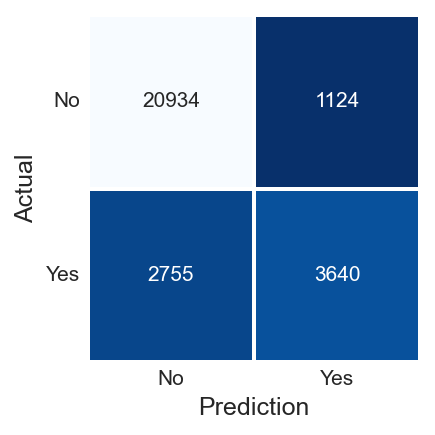

In [165]:
plot_confusion_matrix(xgb)

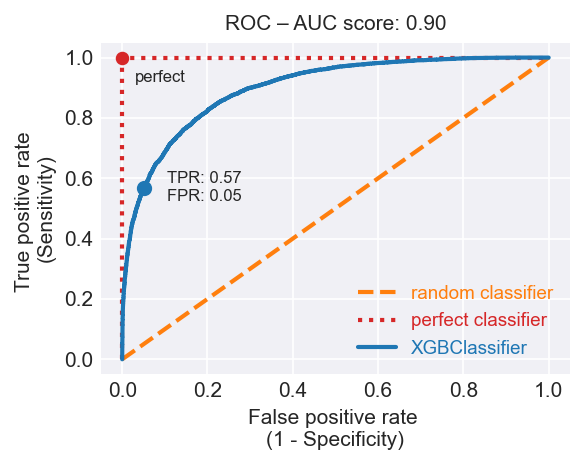

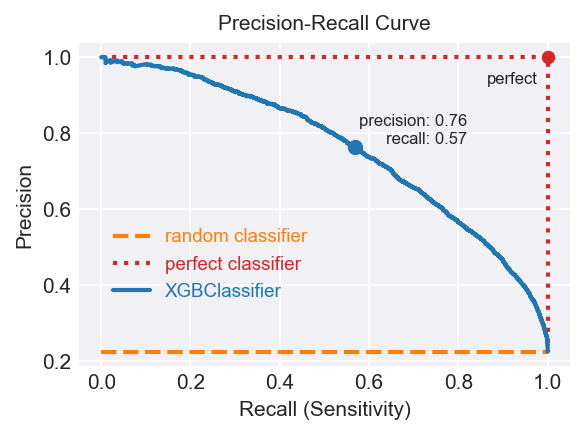

In [166]:
plot_ROC_curve(xgb)
plot_precision_recall_curve(xgb)

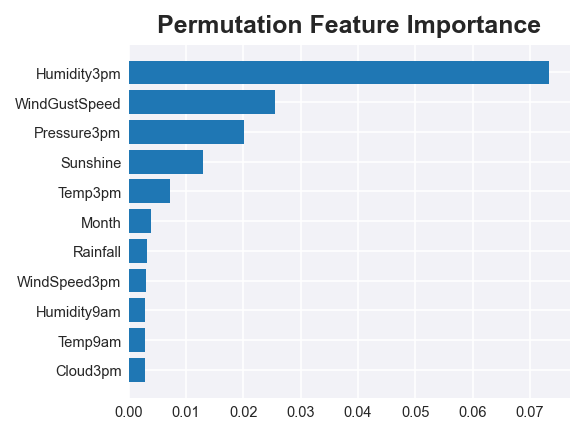

In [169]:
# Takes ~15 min to run when all samples kept
plot_permutation_importance(xgb, frac_samples= 1.0)

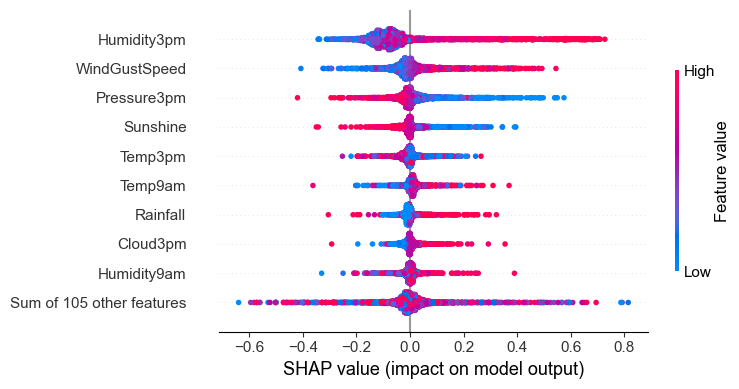

In [181]:
plot_shap_beeswarm(xgb, frac_samples= 0.1)

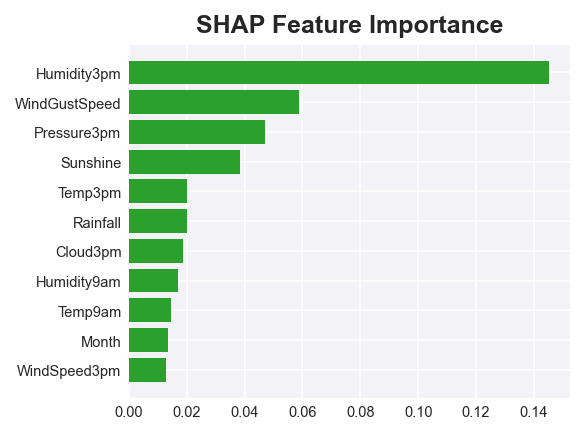

In [170]:
plot_shap_importance(xgb, frac_samples= 0.1)

### Oversampling

In [171]:
# near-default values without much tuning
xgb_oversampled = XGBClassifier(**xgb_near_default_params)

# train on oversampled data
xgb_oversampled.fit(X_train_oversampled, y_train_oversampled)

print_accuracy_f1_score(xgb_oversampled)

Train accuracy: 0.95
Test accuracy: 0.85

Train F1-score: 0.90
Test F1-score: 0.68


In [172]:
# Oversampling - more details on test set
y_pred_test = xgb_oversampled.predict(X_test)

print(metrics.classification_report(y_test, y_pred_test,
                                    target_names=['No','Yes']))

              precision    recall  f1-score   support

          No       0.92      0.88      0.90     22058
         Yes       0.64      0.72      0.68      6395

    accuracy                           0.85     28453
   macro avg       0.78      0.80      0.79     28453
weighted avg       0.85      0.85      0.85     28453



Oversampling caused minor decrease in overall accuracy and minor increase in overall f1-score. However, it caused a significant increase in the recall of "Yes" class from 0.57 to 0.72. That means it catches a lot more rainy days now. This comes with a price though. The tradeoff here is that the recall of "No" class has decreased from 0.95 to 0.88 now. One can choose training on oversampled or original training set depending on the metric of interest.

### Hyperparameter Tuning

Make a grid search over the most important params of the model.

In [861]:
# # Create the grid search params
# param_grid = {'learning_rate': [0.01, 0.03, 0.05],
#               'n_estimators': [300, 500, 800], 
#               'max_depth': [7, 9, 11],  
#               'min_child_weight': [1, 3, 6], 
#               'subsample': [0.7, 0.9], 
#               'colsample_bytree': [0.7, 0.9], 
#               } 

# # Classifier
# xgb = XGBClassifier()

# # Template created with GridSearchCV
# xgb_grid = GridSearchCV(xgb, param_grid, scoring = 'accuracy', n_jobs = -1)
# xgb_grid.fit(X_train, y_train)

# # Print the best params
# print(xgb_grid.best_params_)

{'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 11, 'min_child_weight': 1, 'n_estimators': 800, 'subsample': 0.7}
Best score: 0.8665717108437692


In [984]:
# # print the metrics of the best model
# print_accuracy_f1_score(xgb_grid.best_estimator_)

Train accuracy: 0.981
Test accuracy: 0.866

Train F1-score: 0.956
Test F1-score: 0.656


Comparing the best params with the near-default params used at the beggining, there is minimal improvement on test accuracy (0.866 –> 0.863) and f1-score (0.649 –> 0.656). 

# TRAINING - RANDOM FOREST

Important parameters:
- <b>min_samples_split</b> (default: 2, typical: 2-10): The minimum number of samples required to split an internal node. It helps control overfitting.  

- <b>min_samples_leaf</b> (default: 1, typical: 1-4): min number of data points allowed in a leaf node. Similar to min_samples_split, it helps control overfitting. 

- <b>max_depth</b> (typical: 10-100): deeper trees can model more complex relationships, but as we go deeper, splits become less relevant.

- <b>n_estimators</b> (default: 100, typical: 100-1000): controls the number of trees in the model. Increasing this value generally improves model performance, but can also lead to overfitting and more computation time.

Use usual (near-default) params for now. Tune them later. 

In [173]:
rf_near_default_params= {
                        'n_estimators': 500,
                        'max_depth': 20,
                        'min_samples_leaf': 1,
                        'min_samples_split': 2,
                        'random_state': random_state,
                        'n_jobs': -1,
                        }

In [174]:
rf = RandomForestClassifier(**rf_near_default_params)

rf.fit(X_train, y_train)

print_accuracy_f1_score(rf)

Train accuracy: 0.94
Test accuracy: 0.86

Train F1-score: 0.84
Test F1-score: 0.60


Seems like random forest does not perform any better than XGBoost. XGBoost has higher f1-score and similar overall accuracy.   

# TRAINING - ARTIFICAL NEURAL NETWORK (ANN)

In [182]:
X_train.shape

(113740, 114)

Create a model with 1-2 hidden layers with 10-100 units as a start. Tune them later along with some other hyperparams.

In theory, 

- if the data is linearly separable then we don't need any hidden layers at all. 

- 1 hiden layer can approximate any function that contains a continuous mapping from one finite space to another. 

- 2 hidden layers can represent an arbitrary decision boundary to arbitrary accuracy with rational activation functions and can approximate any smooth mapping to any accuracy. So more than 2 layers is probably not needed here. 

As to the number of units in each layer, it is recommended that it's between the size of the input layer and the size of the output layer.

In [201]:
# Create model
model = Sequential()

# Input layer
model.add(layers.Flatten(input_shape= (X_train.shape[1],)))

# Hidden layer-1
model.add(layers.Dense(units= 64, activation= "relu"))
model.add(layers.Dropout(0.4))

# Hidden layer-2
model.add(layers.Dense(units= 32, activation= "relu"))
model.add(layers.Dropout(0.4))

# Output layer
model.add(layers.Dense(units= 1, activation= "sigmoid"))

# Compile model
model.compile(optimizer= Adam(learning_rate= 0.0003), 
              loss= 'binary_crossentropy', 
              metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 114)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                7360      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9473 (37.00 KB)
Trainable params: 9473 (

In [202]:
fit_history = model.fit(X_train, y_train, 
                        batch_size= 64, 
                        epochs= 20,
                        validation_split= 0.2,
                        verbose= 2)

Epoch 1/20
1422/1422 - 7s - loss: 0.4719 - accuracy: 0.7879 - val_loss: 0.3950 - val_accuracy: 0.8206 - 7s/epoch - 5ms/step
Epoch 2/20
1422/1422 - 4s - loss: 0.4058 - accuracy: 0.8209 - val_loss: 0.3721 - val_accuracy: 0.8340 - 4s/epoch - 3ms/step
Epoch 3/20
1422/1422 - 4s - loss: 0.3874 - accuracy: 0.8329 - val_loss: 0.3580 - val_accuracy: 0.8417 - 4s/epoch - 3ms/step
Epoch 4/20
1422/1422 - 5s - loss: 0.3761 - accuracy: 0.8390 - val_loss: 0.3514 - val_accuracy: 0.8458 - 5s/epoch - 3ms/step
Epoch 5/20
1422/1422 - 4s - loss: 0.3686 - accuracy: 0.8431 - val_loss: 0.3465 - val_accuracy: 0.8480 - 4s/epoch - 3ms/step
Epoch 6/20
1422/1422 - 4s - loss: 0.3623 - accuracy: 0.8453 - val_loss: 0.3429 - val_accuracy: 0.8493 - 4s/epoch - 3ms/step
Epoch 7/20
1422/1422 - 4s - loss: 0.3565 - accuracy: 0.8491 - val_loss: 0.3409 - val_accuracy: 0.8505 - 4s/epoch - 3ms/step
Epoch 8/20
1422/1422 - 4s - loss: 0.3522 - accuracy: 0.8506 - val_loss: 0.3377 - val_accuracy: 0.8521 - 4s/epoch - 3ms/step
Epoch 9/

In [189]:
def plot_training_history(fit_history):
    '''
    Plots loss and accuracy vs. training epoch
    Input: fit_history = model.fit(...)
    Assumes accuracy has been passed to compile method 
    e.g. model.compile(metrics=['accuracy', ..])
    '''

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), 
                                   dpi=150)

    # Loss vs. epoch
    ax1.plot(fit_history.history['loss'], 
             label= 'Training', lw= 4)
    ax1.plot(fit_history.history['val_loss'], 
             label= 'Validation', lw= 4)

    ax1.legend(fontsize=14)
    ax1.set_title('Loss during training', 
                  fontweight= 'bold', fontsize= 14)
    ax1.set_xlabel('Epoch')


    # Accuracy vs. epoch
    ax2.plot(fit_history.history['accuracy'], 
             label= 'Training', lw= 4)
    ax2.plot(fit_history.history['val_accuracy'], 
             label= 'Validation', lw= 4)

    ax2.legend(fontsize=14)
    ax2.set_title('Accuracy during training', 
                  fontweight= 'bold', fontsize= 14)
    ax2.set_xlabel('Epoch')

    fig.tight_layout()
    fig.savefig('Figures/ann_training_history.jpg', dpi=500)

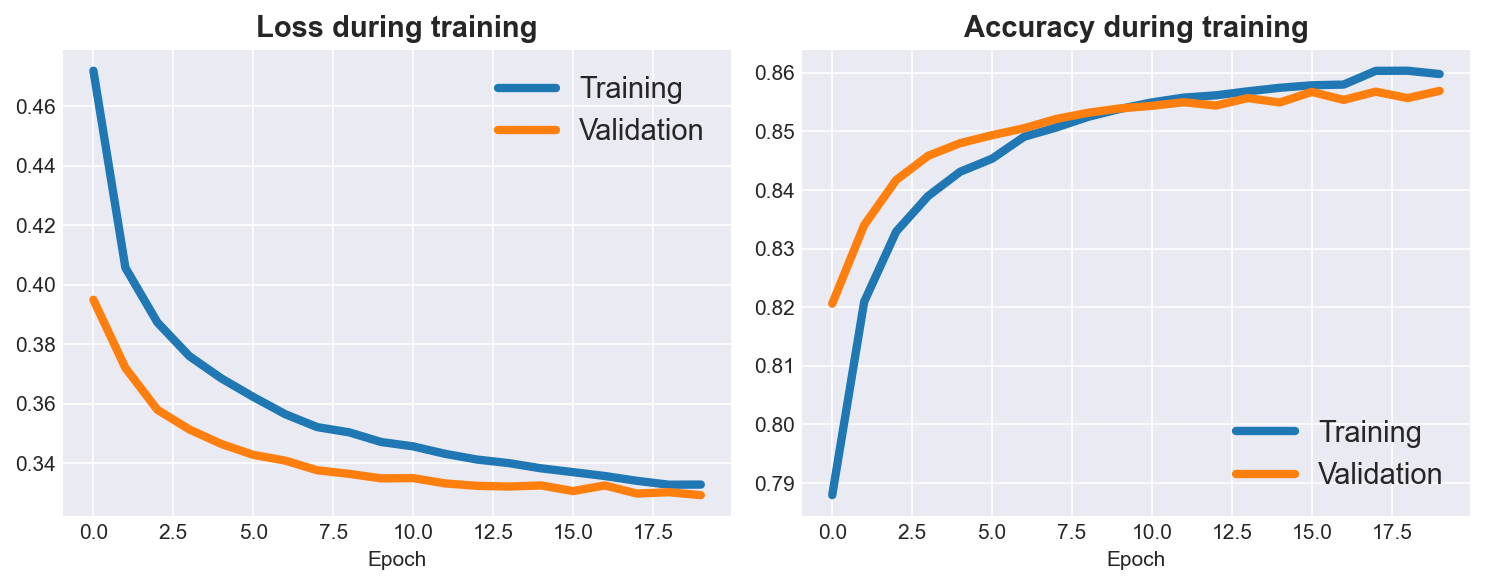

In [203]:
plot_training_history(fit_history)

In [204]:
print_accuracy_f1_score(model)

890/890 [==============================] - 2s 2ms/step
Train accuracy: 0.87
Test accuracy: 0.86

Train F1-score: 0.66
Test F1-score: 0.63


In [205]:
# More metrics
y_pred_probs = model.predict(X_test)  # this is probs not labels
threshold = 0.5
y_pred_test = (y_pred_probs > threshold).astype(int)

print(metrics.classification_report(y_test, y_pred_test))

  1/890 [..............................] - ETA: 36s

890/890 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     22058
         1.0       0.74      0.55      0.63      6395

    accuracy                           0.86     28453
   macro avg       0.81      0.75      0.77     28453
weighted avg       0.85      0.86      0.85     28453



890/890 [==============================] - 4s 5ms/step


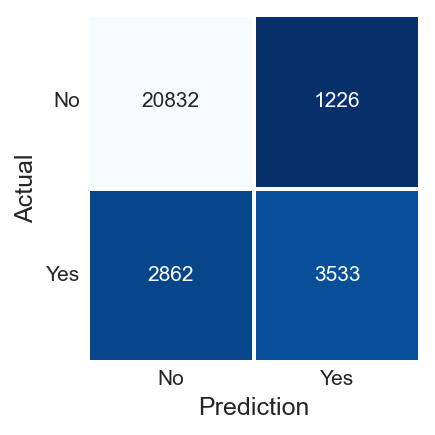

In [214]:
plot_confusion_matrix(model)

  1/890 [..............................] - ETA: 1:09

890/890 [==============================] - 3s 3ms/step


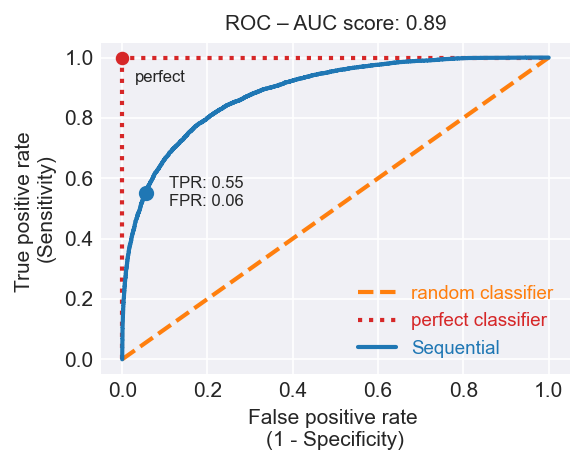

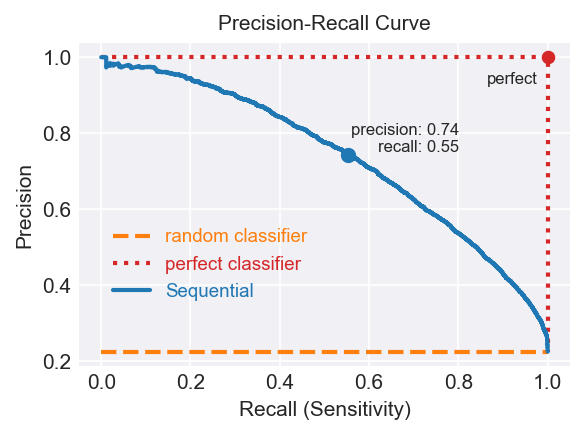

In [206]:
plot_ROC_curve(model)
plot_precision_recall_curve(model)

123/123 [==============================] - 0s 2ms/step


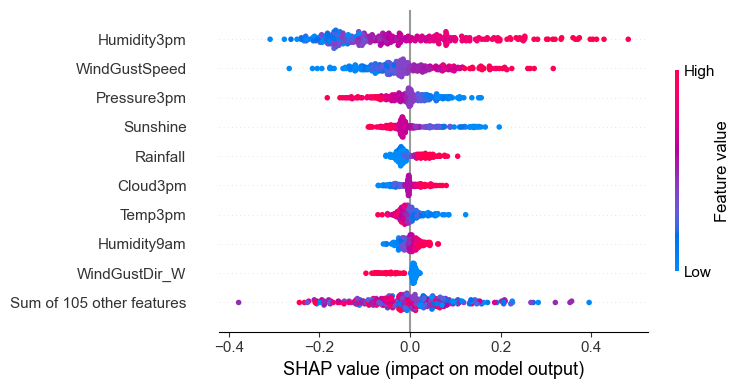

In [209]:
plot_shap_beeswarm(model, frac_samples= 0.01)

 14/144 [=>............................] - ETA: 1s

125/125 [==============================] - 1s 4ms/step


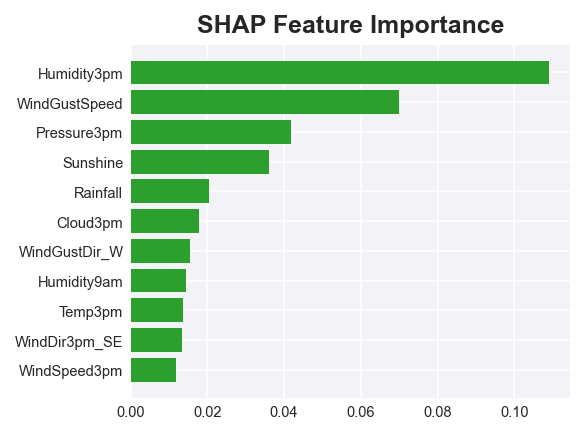

In [208]:
# frac_samples= 0.01 takes ~10 min
plot_shap_importance(model, frac_samples= 0.03)

### Hyperparameter Tuning

I will tune the following hyperparameters of ANN: 
- number of hidden layers: typically between 1-3. Usually 1 or 2 is sufficient

- number of units in each layer: typically between the # input units and output units; usually # units in each layer decreases towards output layer if multiple hidden layers

- dropout rates: typically 0.1-0.5, dropout layers after each dense layer to prevent overfitting

- learning rate: Adam is the widely used, will tune default learning rate of 0.001  

I will use `keras_tuner` library to tune hyperparams ([quick demo](https://keras.io/guides/keras_tuner/getting_started/)).

1) Define the search space

Hyperparamters search for 2 hidden layered model. Search for units in each layer, activations, dropout rates and learning rate of Adam.

In [1406]:
def build_model(hp):
    model = Sequential()

    # input layer
    model.add(layers.Flatten(input_shape= (X_train.shape[1],)))
    
    # hidden layer-1 (tune units and act. functions)
    hp_units = hp.Int('units_1', min_value= 32, max_value= 256, step= 32)
    hp_activations = hp.Choice('activation_1', ['relu', 'tanh'])
    model.add(layers.Dense(units= hp_units, activation= hp_activations,))

    # dropout-1 (tune dropout rate)
    hp_rates = hp.Float('dropout_1', min_value= 0.0, max_value= 0.5, step= 0.1)
    model.add(layers.Dropout(rate= hp_rates))

    # hidden layer-2 (tune units and act. functions)
    hp_units = hp.Int('units_2', min_value= 8, max_value= 256, step= 32)
    hp_activations = hp.Choice('activation_2', ['relu', 'tanh'])
    model.add(layers.Dense(units= hp_units, activation= hp_activations,))

    # dropout-2 (tune dropout rate)
    hp_rates = hp.Float('dropout_2', min_value= 0.0, max_value= 0.5, step= 0.1)
    model.add(layers.Dropout(rate= hp_rates))

    # output layer
    model.add(layers.Dense(units= 1, activation= 'sigmoid'))

    # tune learning rate of Adam
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
                optimizer= Adam(learning_rate= hp_learning_rate), 
                loss= 'binary_crossentropy', metrics= ['accuracy'],
                )
    
    return model

OR hyperparameters search for 1, 2 or 3 hidden layered model. Number of layers is also a hyperparameter in this search. Search for units in each layer, activations, dropout rates and learning rate of Adam 

In [152]:
def build_model(hp):
    model = Sequential()

    # input layer
    model.add(layers.Flatten(input_shape= (X_train.shape[1],)))
    
    # tune number of hidden layers between 1-3
    for layer_i in range(hp.Int("num_hidden_layers", 1, 3)):

        # hidden layer-i (tune units and act. functions)
        hp_units = hp.Int(f'units_{layer_i}', min_value= 8, max_value= 256, step= 32)
        # hp_activations = hp.Choice(f'activation_{layer_i}', ['relu', 'tanh'])
        model.add(layers.Dense(units= hp_units, activation= 'relu'))

        # dropout-i (tune dropout rate)
        hp_rates = hp.Float(f'dropout_{layer_i}', min_value= 0.0, max_value= 0.5, step= 0.1)
        model.add(layers.Dropout(rate= hp_rates))

    # output layer
    model.add(layers.Dense(units= 1, activation= 'sigmoid'))

    # tune learning rate of Adam
    hp_learning_rate = hp.Choice('learning_rate', values= [1e-2, 1e-3, 1e-4])
    model.compile(optimizer= Adam(learning_rate= hp_learning_rate), 
                  loss= 'binary_crossentropy', metrics= ['accuracy'],)
    
    return model

2) Quickly test if the model builds successfully

In [153]:
build_model(keras_tuner.HyperParameters())

3) Choose RandomSearch for tuner and print a summary for the search

In [154]:
tuner = keras_tuner.RandomSearch(
    hypermodel= build_model,
    objective= 'val_accuracy', 
    max_trials= 30,  # max no of random trial within the search space
    overwrite= False,  # overwrite the previous search or start a new one
    project_name= 'keras_tuner_hyperparams_new',  # create a subdir for the search
)

tuner.search_space_summary()

4) Do the actual search, will take hours...

In [156]:
tuner.search(X_train, y_train, epochs= 30, validation_split= 0.2)

Trial 40 Complete [00h 05m 24s]
val_accuracy: 0.8589326739311218

Best val_accuracy So Far: 0.859592080116272
Total elapsed time: 03h 48m 19s


5) Summarize the top performing models

In [157]:
tuner.results_summary()

Results summary
Results in ./keras_tuner_hyperparams
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 03 summary
Hyperparameters:
num_hidden_layers: 2
units_0: 40
dropout_0: 0.2
learning_rate: 0.001
units_1: 136
dropout_1: 0.4
units_2: 232
dropout_2: 0.0
Score: 0.859592080116272

Trial 20 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 40
dropout_0: 0.0
learning_rate: 0.01
units_1: 104
dropout_1: 0.0
units_2: 136
dropout_2: 0.4
Score: 0.8594161868095398

Trial 39 summary
Hyperparameters:
num_hidden_layers: 2
units_0: 40
dropout_0: 0.2
learning_rate: 0.001
units_1: 104
dropout_1: 0.0
units_2: 200
dropout_2: 0.4
Score: 0.8589326739311218

Trial 28 summary
Hyperparameters:
num_hidden_layers: 3
units_0: 136
dropout_0: 0.4
learning_rate: 0.001
units_1: 232
dropout_1: 0.0
units_2: 136
dropout_2: 0.1
Score: 0.8586249351501465

Trial 32 summary
Hyperparameters:
num_hidden_layers: 1
units_0: 40
dropout_0: 0.1
learning_rate: 0.01
units_1: 8
dropout_1: 0.1
unit

### Save the Top Performing Model

In [1109]:
# # save the entire model as a `.keras` zip archive.
# model.save('model.keras')

# # reload previously saved model
# loaded_model = keras.models.load_model('model.keras')

# # show the model architecture
# loaded_model.summary()